## Projet 3 : Préparez des données pour un organisme de santé publique

## Contexte

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts, qui est open source afin de permettre à tous de connaitre la qualité nutritionnelle des produits.

Aujourd'hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes.

L'agence Santé publique France confie à notre entreprise la création d'un système de suggestion ou d'auto-complétion pour aider les usagers à remplir plus efficacement la base de données, même si cette dernière venait à être légèrement modifiée

Notre objectif : nettoyer et explorer les données en interne afin de déterminer la faisabilité de cette idée d'applications. 

## Librairies utilisées avec le langage Python:

In [1]:
# Importation des librairies
import scikit_posthocs as sp
import numpy as np
import pandas as pd
import pyarrow as pya
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import scipy.stats as stats
from scipy.stats import levene
import statsmodels.formula.api as smf
import pingouin as pg 
from pingouin import welch_anova
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

## Visualisation du tableau de données brutes


In [2]:
# Chargement des données brutes du fichier CSV avec des virgules pour séparateur
data=pd.read_csv('fr.openfoodfacts.org.products.csv', delimiter = '\t')
# Visualisation des 5 premières lignes
data.head(5)

code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   
2                   NaN                     0.0                     0.0   
3                   NaN                    12.0                    12.0   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]

Les champs sont séparés en quatre sections :

##### Les informations générales sur la fiche du produit :
- code : codebarre du produit ( EAN-13 ou  codes internes pour certains magasins). Pour les produits sans codebarres, Open Food Fact attribue un numéro commençant par le préfixe réservé 200.
- url : url de la page du produit sur Open Food Facts
- creator : contributeur qui a ajouté le produit pour la première fois
- created_t : date à laquelle le produit a été ajouté (timestamp)
- created_datetime : date à laquelle le produit a été ajouté (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- last_modified_t : date à laquelle le produit a été modifié pour la dernière fois (timestamp)
- last_modified_datetime : date à laquelle le produit a été modifié pour la dernière fois (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- product_name : nom du produit
- generic_name : nom générique
- quantity : quantité et unité

##### Un ensemble de tags (catégorie du produit, origine des ingrédients, liste des pays où il est vendu, ...)

##### Les ingrédients composants les produits et leurs additifs éventuels

##### Des informations nutritionnelles (quantité en gramme d'un nutriment pour 100 grammes du produit)

Pour plus d'informations sur les différentes variables : https://world.openfoodfacts.org/data/data-fields.txt

## Etude des données : nombre de lignes & colonnes, types des données et statistiques

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Nous avons donc un data frame composé de 162 variables dont 106 sont des type flottant, et 56 de type objet.
Dans ce data frame, 320771 produits ont été entrés.

Interessons nous aux variables avec le plus de valeurs manquantes afin de trouver notre variable cible :

In [4]:
 # Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables et de filtrer sur les variables avec un pourcentage de valeurs manquantes supérieur à l'entrée percent

def show_miss_val(data,percent):  
    variables = []
    miss_val = []
    
    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean())

    output = pd.DataFrame({
        'variable': variables, 
        'miss_val': miss_val 
    })    
        
    return output[output['miss_val']>=percent].sort_values('miss_val')

In [5]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable avec un filtre de 0.7 pour n'avoir que les colonnes avec plus de 70% de valeurs manquantes
data_vm=show_miss_val(data,0.70)
data_vm.head(120)

variable  miss_val
55         pnns_groups_2  0.705426
54         pnns_groups_1  0.714710
16         categories_fr  0.736850
14            categories  0.736854
15       categories_tags  0.736919
..                   ...       ...
94     elaidic-acid_100g  1.000000
98    nervonic-acid_100g  1.000000
97      erucic-acid_100g  1.000000
52    nutrition_grade_uk  1.000000
161  water-hardness_100g  1.000000

[119 rows x 2 columns]

In [6]:
data['pnns_groups_1'].describe()

count       91513
unique         14
top       unknown
freq        22624
Name: pnns_groups_1, dtype: object

In [7]:
data['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

La variable 'pnns_groups_1' parait être une bonne variable cible avec 71.5% de valeurs manquantes et seulement 14 valeurs possibles.

## Nettoyage du dataframe

Nous pouvons par contre remarquer que certaines valeurs sont les mêmes et que seules la typographie change. Remédions à cela :

In [8]:
def pnnsgroup1_imputation (data) :
    compt=0
    for item in data['pnns_groups_1'] :
        if item=='salty-snacks' : data.loc[compt,'pnns_groups_1']= 'Salty snacks'
        if item=='cereals-and-potatoes' : data.loc[compt,'pnns_groups_1']= 'Cereals and potatoes'
        if item=='sugary-snacks' : data.loc[compt,'pnns_groups_1']= 'Sugary snacks'
        if item=='fruits-and-vegetables' : data.loc[compt,'pnns_groups_1']= 'Fruits and vegetables'
        compt+=1
    return data

In [9]:
data_1 = pnnsgroup1_imputation (data)
data_1['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks'], dtype=object)

Nous avons donc maintenant 10 valeurs possibles pour notre variable cible. 

Supprimons ensuite les lignes qui n'ont pas de valeurs pour la variable cible :

In [10]:
#  Fonction supprimant les lignes produits qui ont une valeur manquante pour la variable cible
def supp_nan_cible (data) :
    valeur=['unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks']
# Cast de la variable cible comme objet
    data_1['pnns_groups_1']=data['pnns_groups_1'].astype(object)
# Imputation à NaN de toutes les valeurs de 'pnns_groups_1' différentes de celles attendues
    data_1.loc[~data_1['pnns_groups_1'].isin(valeur)]='NaN'
# Suppression des lignes à 'NaN'
    data_1.drop(data_1[data_1['pnns_groups_1'] == 'NaN'].index, inplace=True)
    return data_1

data_2=supp_nan_cible(data_1)
data_pnns_1 =data_2.groupby('pnns_groups_1', dropna=False)['code'].count()
print(data_pnns_1)

pnns_groups_1
Beverages                   9033
Cereals and potatoes        8458
Composite foods             6747
Fat and sauces              5216
Fish Meat Eggs              8041
Fruits and vegetables       6895
Milk and dairy products     8825
Salty snacks                2810
Sugary snacks              12864
unknown                    22624
Name: code, dtype: int64


In [11]:
data_2.shape

(91513, 162)

Il reste 91513 lignes de produits pour poursuivre notre analyse. 

Cherchons maintenant à conserver des variables avec peu de valeurs manquantes et pertinentes pour prédire notre variable cible :

In [12]:
data_vm=show_miss_val(data_2,0)
data_vm.head(50)

variable  miss_val
0                                       code  0.000000
54                             pnns_groups_1  0.000000
55                             pnns_groups_2  0.000000
56                                    states  0.000000
57                               states_tags  0.000000
6                     last_modified_datetime  0.000000
58                                 states_fr  0.000000
3                                  created_t  0.000000
1                                        url  0.000000
5                            last_modified_t  0.000000
4                           created_datetime  0.000011
2                                    creator  0.000022
31                                 countries  0.001661
33                              countries_fr  0.001661
32                            countries_tags  0.001661
7                               product_name  0.032946
12                                    brands  0.041721
13                               brands_tags  0.041754
9                                   quantity  0.110181
60                          main_category_fr  0.110640
59                             main_category  0.110640
15                           categories_tags  0.110640
14                                categories  0.110640
16                             categories_fr  0.110640
11                            packaging_tags  0.194726
10                                 packaging  0.194759
34                          ingredients_text  0.232885
46               ingredients_from_palm_oil_n  0.232885
49   ingredients_that_may_be_from_palm_oil_n  0.232885
42                               additives_n  0.232885
43                                 additives  0.233202
63                               energy_100g  0.259001
112                            proteins_100g  0.266279
65                                  fat_100g  0.296439
101                       carbohydrates_100g  0.301345
116                                salt_100g  0.302055
117                              sodium_100g  0.302143
102                              sugars_100g  0.304929
66                        saturated-fat_100g  0.308262
62                           image_small_url  0.308754
61                                 image_url  0.308754
53                        nutrition_grade_fr  0.324642
159                  nutrition-score-uk_100g  0.324642
158                  nutrition-score-fr_100g  0.324642
29                           purchase_places  0.386065
8                               generic_name  0.439446
30                                    stores  0.452154
23                                 labels_fr  0.539169
22                               labels_tags  0.539169
21                                    labels  0.540109

Voici les variables qu'il semble pertinent de garder pour notre analyse et la prédiction de notre variable cible : pnns_groups_1, pnns_groups_2, product_name, main_category_fr, energy_100g, proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,sugars_100g,saturated-fat_100g,nutrition_grade_fr, nutrition-score-fr_100g	

In [13]:
#  Fonction permettant de ne garder que les variables d'intérêt définies au préalable
def sel_var_interet (data) :
    variable =['pnns_groups_1', 'pnns_groups_2', 'product_name', 'main_category_fr', 'energy_100g', 'proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g',
               'sugars_100g','saturated-fat_100g','nutrition_grade_fr', 'nutrition-score-fr_100g']
    del_var=[]
    for var in data.columns :
        if var not in variable : del_var.append(var)
    data=data.drop(del_var,axis=1)
    return data
    

In [75]:
data_3 = sel_var_interet(data_2)

In [15]:
data_3.head(10)

product_name nutrition_grade_fr          pnns_groups_1  \
46                    Filet de bœuf                NaN                unknown   
106                  Lion Peanut x2                  e                unknown   
136                         Twix x2                NaN                unknown   
138                  Pack de 2 Twix                NaN                unknown   
174                    Salade Cesar                  c  Fruits and vegetables   
175  Danoises à la cannelle roulées                NaN          Sugary snacks   
177                           Flute                NaN   Cereals and potatoes   
180    Chaussons tressés aux pommes                  c          Sugary snacks   
181             Pain Burger Artisan                  b                unknown   
182               lentilles vertes                 NaN   Cereals and potatoes   

          pnns_groups_2                         main_category_fr energy_100g  \
46              unknown                           Filet-de-boeuf         NaN   
106             unknown                                      NaN      1883.0   
136             unknown                                      NaN         NaN   
138             unknown                                      NaN      1481.0   
174          Vegetables                            Légumes frais      1210.0   
175  Biscuits and cakes                              Pâtisseries      1520.0   
177               Bread                                    Pains         NaN   
180  Biscuits and cakes                              Pâtisseries      1090.0   
181             unknown                                 Boulange      1160.0   
182             Legumes  Aliments et boissons à base de végétaux         NaN   

    fat_100g saturated-fat_100g carbohydrates_100g sugars_100g proteins_100g  \
46       NaN                NaN                NaN         NaN           NaN   
106     20.0               12.5               70.0        57.5           2.5   
136      NaN                NaN                NaN         NaN           NaN   
138     4.17                NaN              77.08         NaN          6.25   
174     12.0                7.0               23.0         0.0          22.0   
175     14.4                NaN               54.1        28.1          4.79   
177      NaN                NaN                NaN         NaN           NaN   
180     10.7                2.0               38.7        24.7          3.33   
181     1.11              0.333               53.3        1.11          10.0   
182      NaN                NaN                NaN         NaN           NaN   

    salt_100g sodium_100g nutrition-score-fr_100g  
46        NaN         NaN                     NaN  
106   0.09652       0.038                    22.0  
136       NaN         NaN                     NaN  
138       NaN         NaN                     NaN  
174      2.16        0.85                     6.0  
175     0.922       0.363                     NaN  
177       NaN         NaN                     NaN  
180     0.647       0.255                     9.0  
181      1.52         0.6                     1.0  
182       NaN         NaN                     NaN

Recherchons maintenant les doublons. Nous considèrerons que les doublons sont les lignes identiques pour la totalité des 14 variables d'intérêt choisies.

In [76]:
data_3.duplicated(subset=['pnns_groups_1', 'pnns_groups_2', 'product_name', 'main_category_fr', 'energy_100g', 'proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g',
               'sugars_100g','saturated-fat_100g','nutrition_grade_fr', 'nutrition-score-fr_100g']).sum()


5271

Il existe 5271 duplicatas. Supprimons les :

In [95]:
data_4 = data_3.drop_duplicates()
data_4.shape

(86242, 14)

Il nous reste un dataframe de 86242 lignes ou produits avec 14 variables pour notre analyse. Regardons le de plus près :

In [18]:
data_4.dtypes

product_name               object
nutrition_grade_fr         object
pnns_groups_1              object
pnns_groups_2              object
main_category_fr           object
energy_100g                object
fat_100g                   object
saturated-fat_100g         object
carbohydrates_100g         object
sugars_100g                object
proteins_100g              object
salt_100g                  object
sodium_100g                object
nutrition-score-fr_100g    object
dtype: object

Castons les variables finissant par _100g comme flottant puisque ce sont des variables quantitatives :

In [96]:
data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g']]=data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g']].apply(pd.to_numeric)


In [20]:
 data_4.dtypes

product_name                object
nutrition_grade_fr          object
pnns_groups_1               object
pnns_groups_2               object
main_category_fr            object
energy_100g                float64
fat_100g                   float64
saturated-fat_100g         float64
carbohydrates_100g         float64
sugars_100g                float64
proteins_100g              float64
salt_100g                  float64
sodium_100g                float64
nutrition-score-fr_100g    float64
dtype: object

In [21]:
#  Variables quantitatives :
data_4.describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  6.666800e+04  63250.000000        62233.000000        62804.000000   
mean   1.150775e+03     13.398231            5.339084           27.965714   
std    1.263567e+04     17.151856            8.280689           27.403659   
min    0.000000e+00      0.000000            0.000000            0.000000   
25%    3.930000e+02      1.100000            0.300000            4.400000   
50%    1.009000e+03      6.600000            1.900000           14.800000   
75%    1.644000e+03     21.092500            7.300000           53.300000   
max    3.251373e+06    380.000000          210.000000          190.000000   

        sugars_100g  proteins_100g     salt_100g   sodium_100g  \
count  62532.000000   66008.000000  62789.000000  62781.000000   
mean      13.222948       7.503197      1.154210      0.454462   
std       18.806121       7.612317      4.870462      1.917472   
min       -0.100000       0.000000      0.000000      0.000000   
25%        1.000000       1.700000      0.070000      0.027559   
50%        4.200000       5.800000      0.508000      0.200000   
75%       17.000000      10.300000      1.200000      0.472441   
max      134.000000     100.000000    297.600000    117.165354   

       nutrition-score-fr_100g  
count             60741.000000  
mean                  8.433282  
std                   9.105679  
min                 -15.000000  
25%                   1.000000  
50%                   8.000000  
75%                  15.000000  
max                  40.000000

In [22]:
#  Variables qualitatives :
data_4.describe(exclude=[np.number])

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85284              60741         86242         86242   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16562         20115         20115   

       main_category_fr  
count             77998  
unique             3543  
top            Boissons  
freq               3031

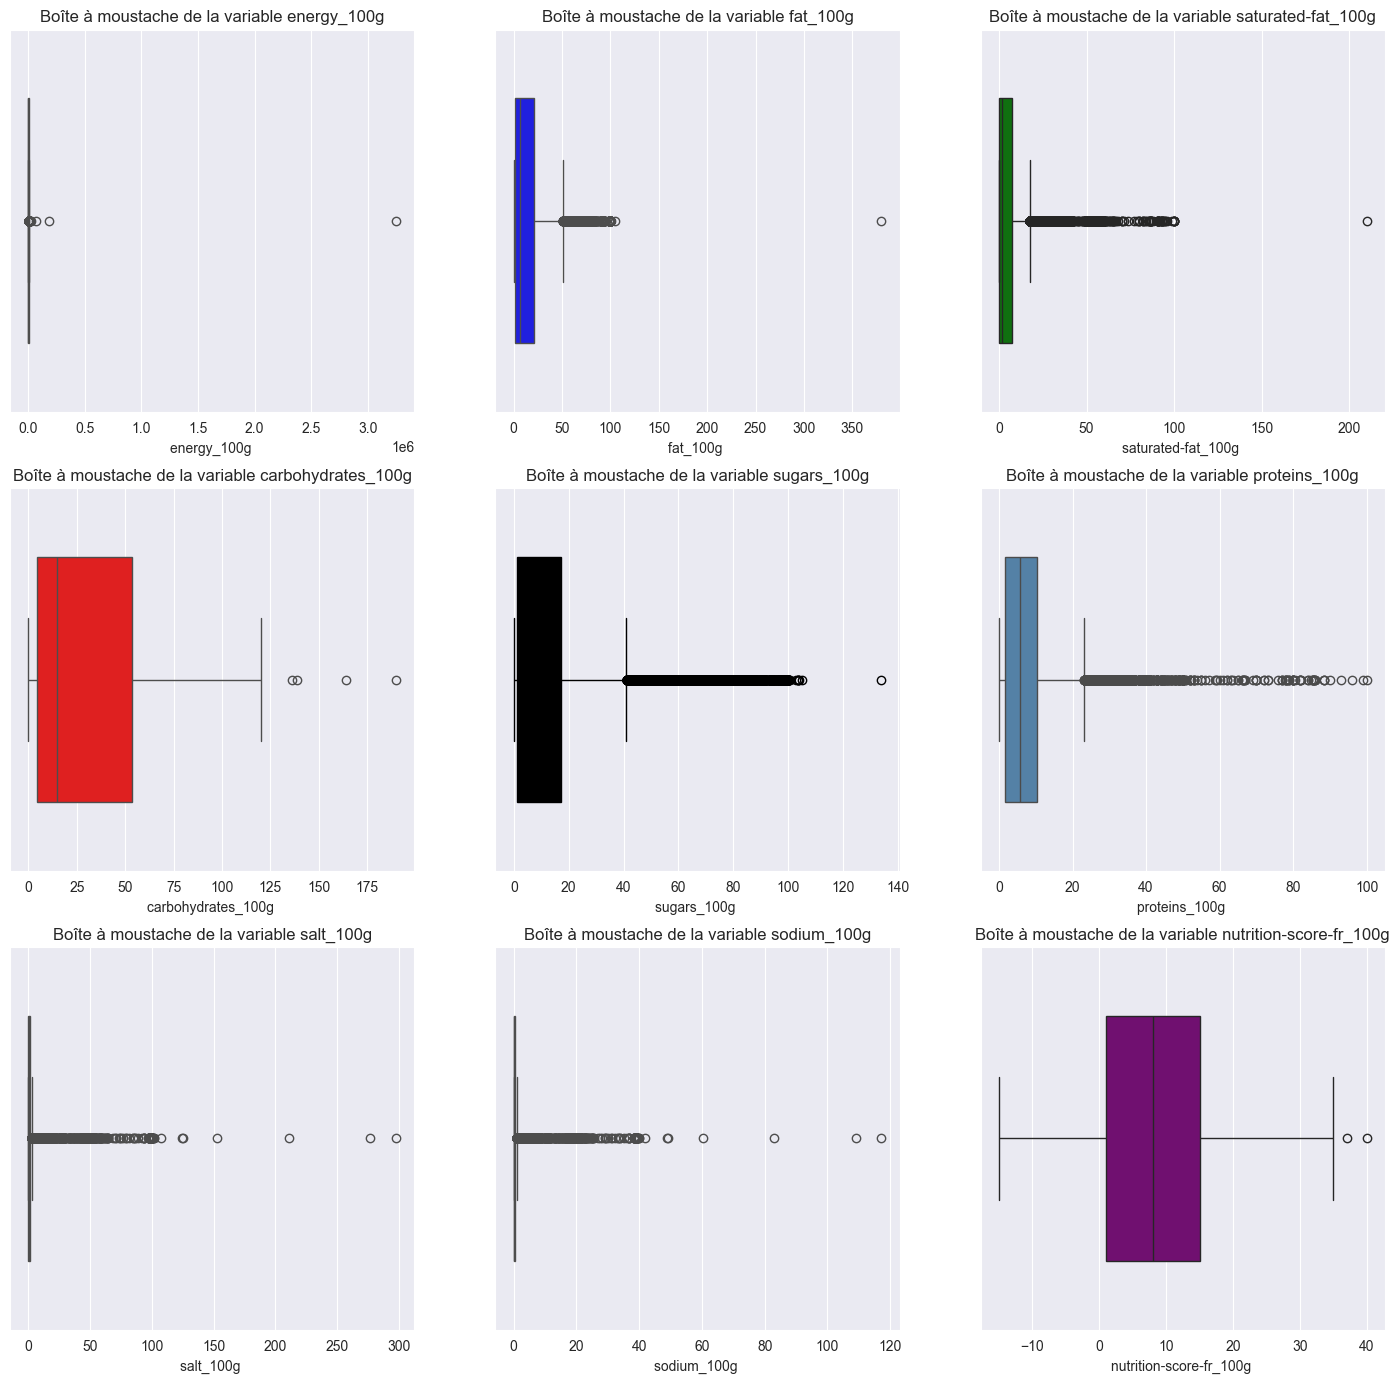

In [97]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('carbohydrates_100g','red',4),('sugars_100g','black',5),('proteins_100g','steelblue',6),('salt_100g','orange',7),('sodium_100g','darkorange',8),('nutrition-score-fr_100g','purple',9)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 10))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
    
    # # Création des boîtes à moustaches
    axes = figure.add_subplot(3, 3, place)
    sns.boxplot(data=data_4,x=variable, ax=axes,gap=0.2,legend=False, color=color, showfliers=True, log_scale=False)
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")


Nous pouvons observer des valeurs aberrantes pour les variables quantitatives. 

Toutes les variables qui finissent par '_100g' sont exprimés en g (excepté pour l'energie, en KJ, et le nutriscore) et ne peuvent donc pas dépasser 100g dans 100g de produit. Les valeurs de ces variables ne peuvent pas non plus être négatives.

Excepté pour l'energie et le nutriscore, imputons en Nan toutes les valeurs négatives ou supérieures à 100 pour les variables finissant par '_100g'.

Concernant l'énergie, après des recherches, il semblerait que l'énergie maximum en kJ pour 100g est d'environ 3800kJ. Il semble pertinent d'imputer en Nan les valeurs de cette variable qui sont supérieures à 4000kJ.

Les autres valeurs aberrantes ne s'expliquent pas par une approche métier, nous les conservons donc.

In [82]:
# Fonction permettant de ne garder que les variables quantitatives du Dataframe
def col_quant (data) :
    del_var=[]
    variables = data.columns
    for item in variables :
        if data[item].dtypes == 'object' :
            del_var.append(item)
    output = data.drop(columns=del_var, axis = 1)
    return output

# Imputation des valeur aberrantes en Nan
def imput_nan_imp_values_100gcol(data) :
    variables = ['energy_100g','energy-kj_100g','energy-kcal_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
    data_quant=col_quant(data)
    df=data_quant.columns
    for item in df :
        if item =='energy_100g' :
            data.loc[(data[item]>4000), item]= np.nan
        elif item not in variables :
            data.loc[(data[item]<0) |(data[item]>100), item]= np.nan
        else : pass
    return data

In [83]:
data_clean=imput_nan_imp_values_100gcol(data_4)

# Nouvelles statistiques des colonnes quantitatives sans les valeurs aberrantes
data_clean.describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  66638.000000  63247.000000        62232.000000        62791.000000   
mean    1095.769950     13.389602            5.335795           27.946368   
std      782.077231     17.082771            8.240013           27.370702   
min        0.000000      0.000000            0.000000            0.000000   
25%      393.000000      1.100000            0.300000            4.400000   
50%     1009.000000      6.600000            1.900000           14.800000   
75%     1643.000000     21.000000            7.300000           53.300000   
max     4000.000000    100.000000          100.000000          100.000000   

        sugars_100g  proteins_100g     salt_100g   sodium_100g  \
count  62523.000000   66008.000000  62780.000000  62779.000000   
mean      13.211141       7.503197      1.130506      0.450874   
std       18.776997       7.612317      4.365458      1.808908   
min        0.000000       0.000000      0.000000      0.000000   
25%        1.000000       1.700000      0.070000      0.027559   
50%        4.200000       5.800000      0.508000      0.200000   
75%       17.000000      10.300000      1.200000      0.472441   
max      100.000000     100.000000    100.000000     83.000000   

       nutrition-score-fr_100g  
count             60741.000000  
mean                  8.433282  
std                   9.105679  
min                 -15.000000  
25%                   1.000000  
50%                   8.000000  
75%                  15.000000  
max                  40.000000

Pour un souci de facilité, automatisons cette première étape de nettoyage avant d'approfondir l'analyse :

In [25]:
#  Fonction automatisant le nettoyage du dataframe en utilisant les fonctions développées précédemment
def nettoyage_df (data) :
    data_1 = pnnsgroup1_imputation (data)
    data_2=supp_nan_cible(data_1)
    data_3 = sel_var_interet(data_2)
    data_4 = data_3.drop_duplicates(ignore_index=True)
    data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g']]=data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g']].apply(pd.to_numeric)
    data_clean=imput_nan_imp_values_100gcol(data_4)
    return data_clean

In [100]:
data_clean = nettoyage_df(data)
data_clean.describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  66638.000000  63247.000000        62232.000000        62791.000000   
mean    1095.769950     13.389602            5.335795           27.946368   
std      782.077231     17.082771            8.240013           27.370702   
min        0.000000      0.000000            0.000000            0.000000   
25%      393.000000      1.100000            0.300000            4.400000   
50%     1009.000000      6.600000            1.900000           14.800000   
75%     1643.000000     21.000000            7.300000           53.300000   
max     4000.000000    100.000000          100.000000          100.000000   

        sugars_100g  proteins_100g     salt_100g   sodium_100g  \
count  62523.000000   66008.000000  62780.000000  62779.000000   
mean      13.211141       7.503197      1.130506      0.450874   
std       18.776997       7.612317      4.365458      1.808908   
min        0.000000       0.000000      0.000000      0.000000   
25%        1.000000       1.700000      0.070000      0.027559   
50%        4.200000       5.800000      0.508000      0.200000   
75%       17.000000      10.300000      1.200000      0.472441   
max      100.000000     100.000000    100.000000     83.000000   

       nutrition-score-fr_100g  
count             60741.000000  
mean                  8.433282  
std                   9.105679  
min                 -15.000000  
25%                   1.000000  
50%                   8.000000  
75%                  15.000000  
max                  40.000000

In [27]:
data_clean.describe(exclude=[np.number])  

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85284              60741         86242         86242   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16562         20115         20115   

       main_category_fr  
count             77998  
unique             3543  
top            Boissons  
freq               3031

In [28]:
data_clean.shape

(86242, 14)

## Analyses et visualisations

Regardons la distribution des variables catégorielles :

<Axes: title={'center': 'Répartition du nutriscore dans nos données sélectionnées'}, xlabel='nutrition_grade_fr', ylabel='count'>

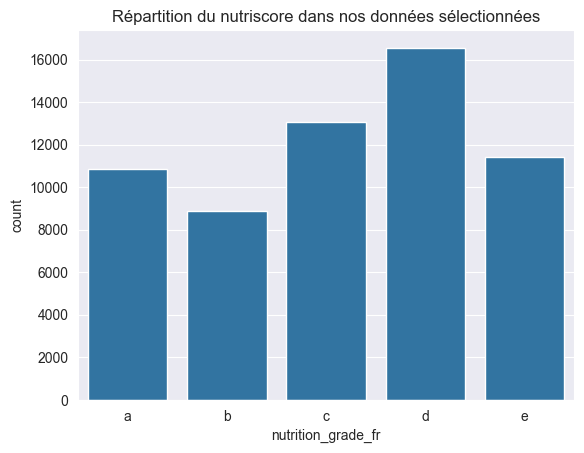

In [101]:
plt.title(f'Répartition du nutriscore dans nos données sélectionnées')
sns.countplot(data_clean, x="nutrition_grade_fr", order=['a','b','c','d','e'])

In [102]:
# Calcul de la répartition du nutriscore
data_nutri =data_clean.groupby('nutrition_grade_fr', dropna=False)['pnns_groups_1'].count()
print(data_nutri)

nutrition_grade_fr
a      10828
b       8879
c      13039
d      16562
e      11433
NaN    25501
Name: pnns_groups_1, dtype: int64


Text(0.5, 1.0, 'Proportion des nutriscores de nos données sélectionnées')

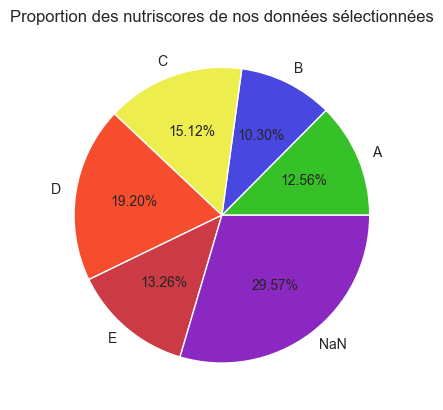

In [103]:
labels = ['A', 'B', 'C', 'D', 'E','NaN']
colors = ['#36c128','#4848E1','#EDED4E','#F64D2F','#CC3B45','#8b28c1']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_nutri, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des nutriscores de nos données sélectionnées")

Il y a un nombre non négligeable (presque 30%) de valeurs de nutrigrade manquants. Regardons si un nutriscore est renseigné afin de pouvoir l'imputer :

In [104]:
nutriscore_mv=data_clean.loc[(data_clean['nutrition-score-fr_100g'].isna()==False) & (data_clean['nutrition_grade_fr']=='Nan')]
nutriscore_mv.shape

(0, 14)

Aucun nutriscore n'est renseigné pour un nutrigrade manquant. L'imputation n'est donc pas évidente.

In [105]:
# Création d'une liste ordonné de 'pnns_groups_1' en fonction du plus grand nombre de nutriscore 'a'
nutriscore_order = data_clean.groupby('pnns_groups_1',as_index=False)['nutrition_grade_fr'].value_counts()
nutriscore_order=nutriscore_order.loc[(nutriscore_order['nutrition_grade_fr']=='a'), ['pnns_groups_1','count']]
nutriscore_order=nutriscore_order.sort_values(by="count", ascending=False)

<Axes: title={'center': 'Nombre de produits par catégorie et nutriscore de nos données sélectionnées'}, xlabel='count', ylabel='pnns_groups_1'>

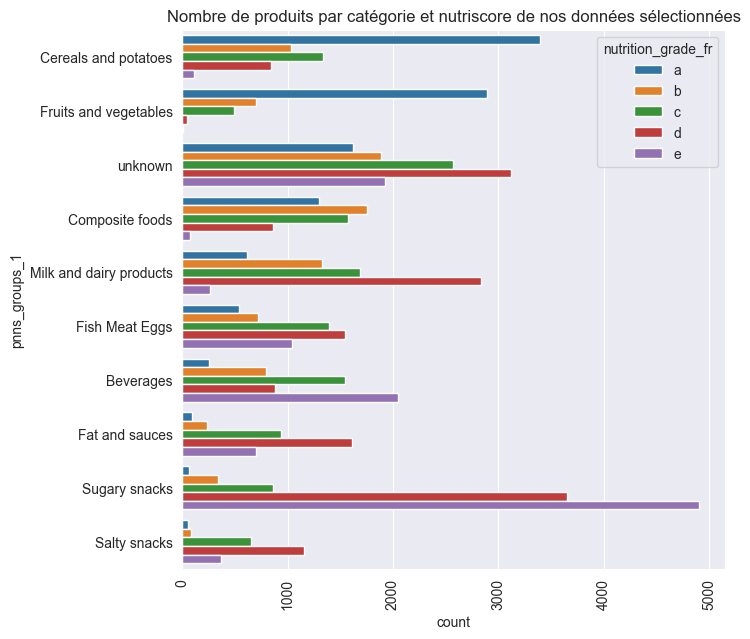

In [107]:
plt.figure(figsize=(7, 7))
plt.xticks(rotation = 'vertical')
plt.title(f'Nombre de produits par catégorie et nutriscore de nos données sélectionnées')
sns.countplot(data_clean, y="pnns_groups_1",hue="nutrition_grade_fr",hue_order=['a','b','c','d','e'], order=nutriscore_order['pnns_groups_1'])

Sans surprise, on aperçoit que les catégories avec le moins de produits avec de bons nutriscores sont les catégories salées, sucrées, graisses,...

Passons aux variables quantitatives :

(on n'affichera pas les valeurs atypiques sur les boîtes à moustaches pour bien visualiser la distribution des variables)

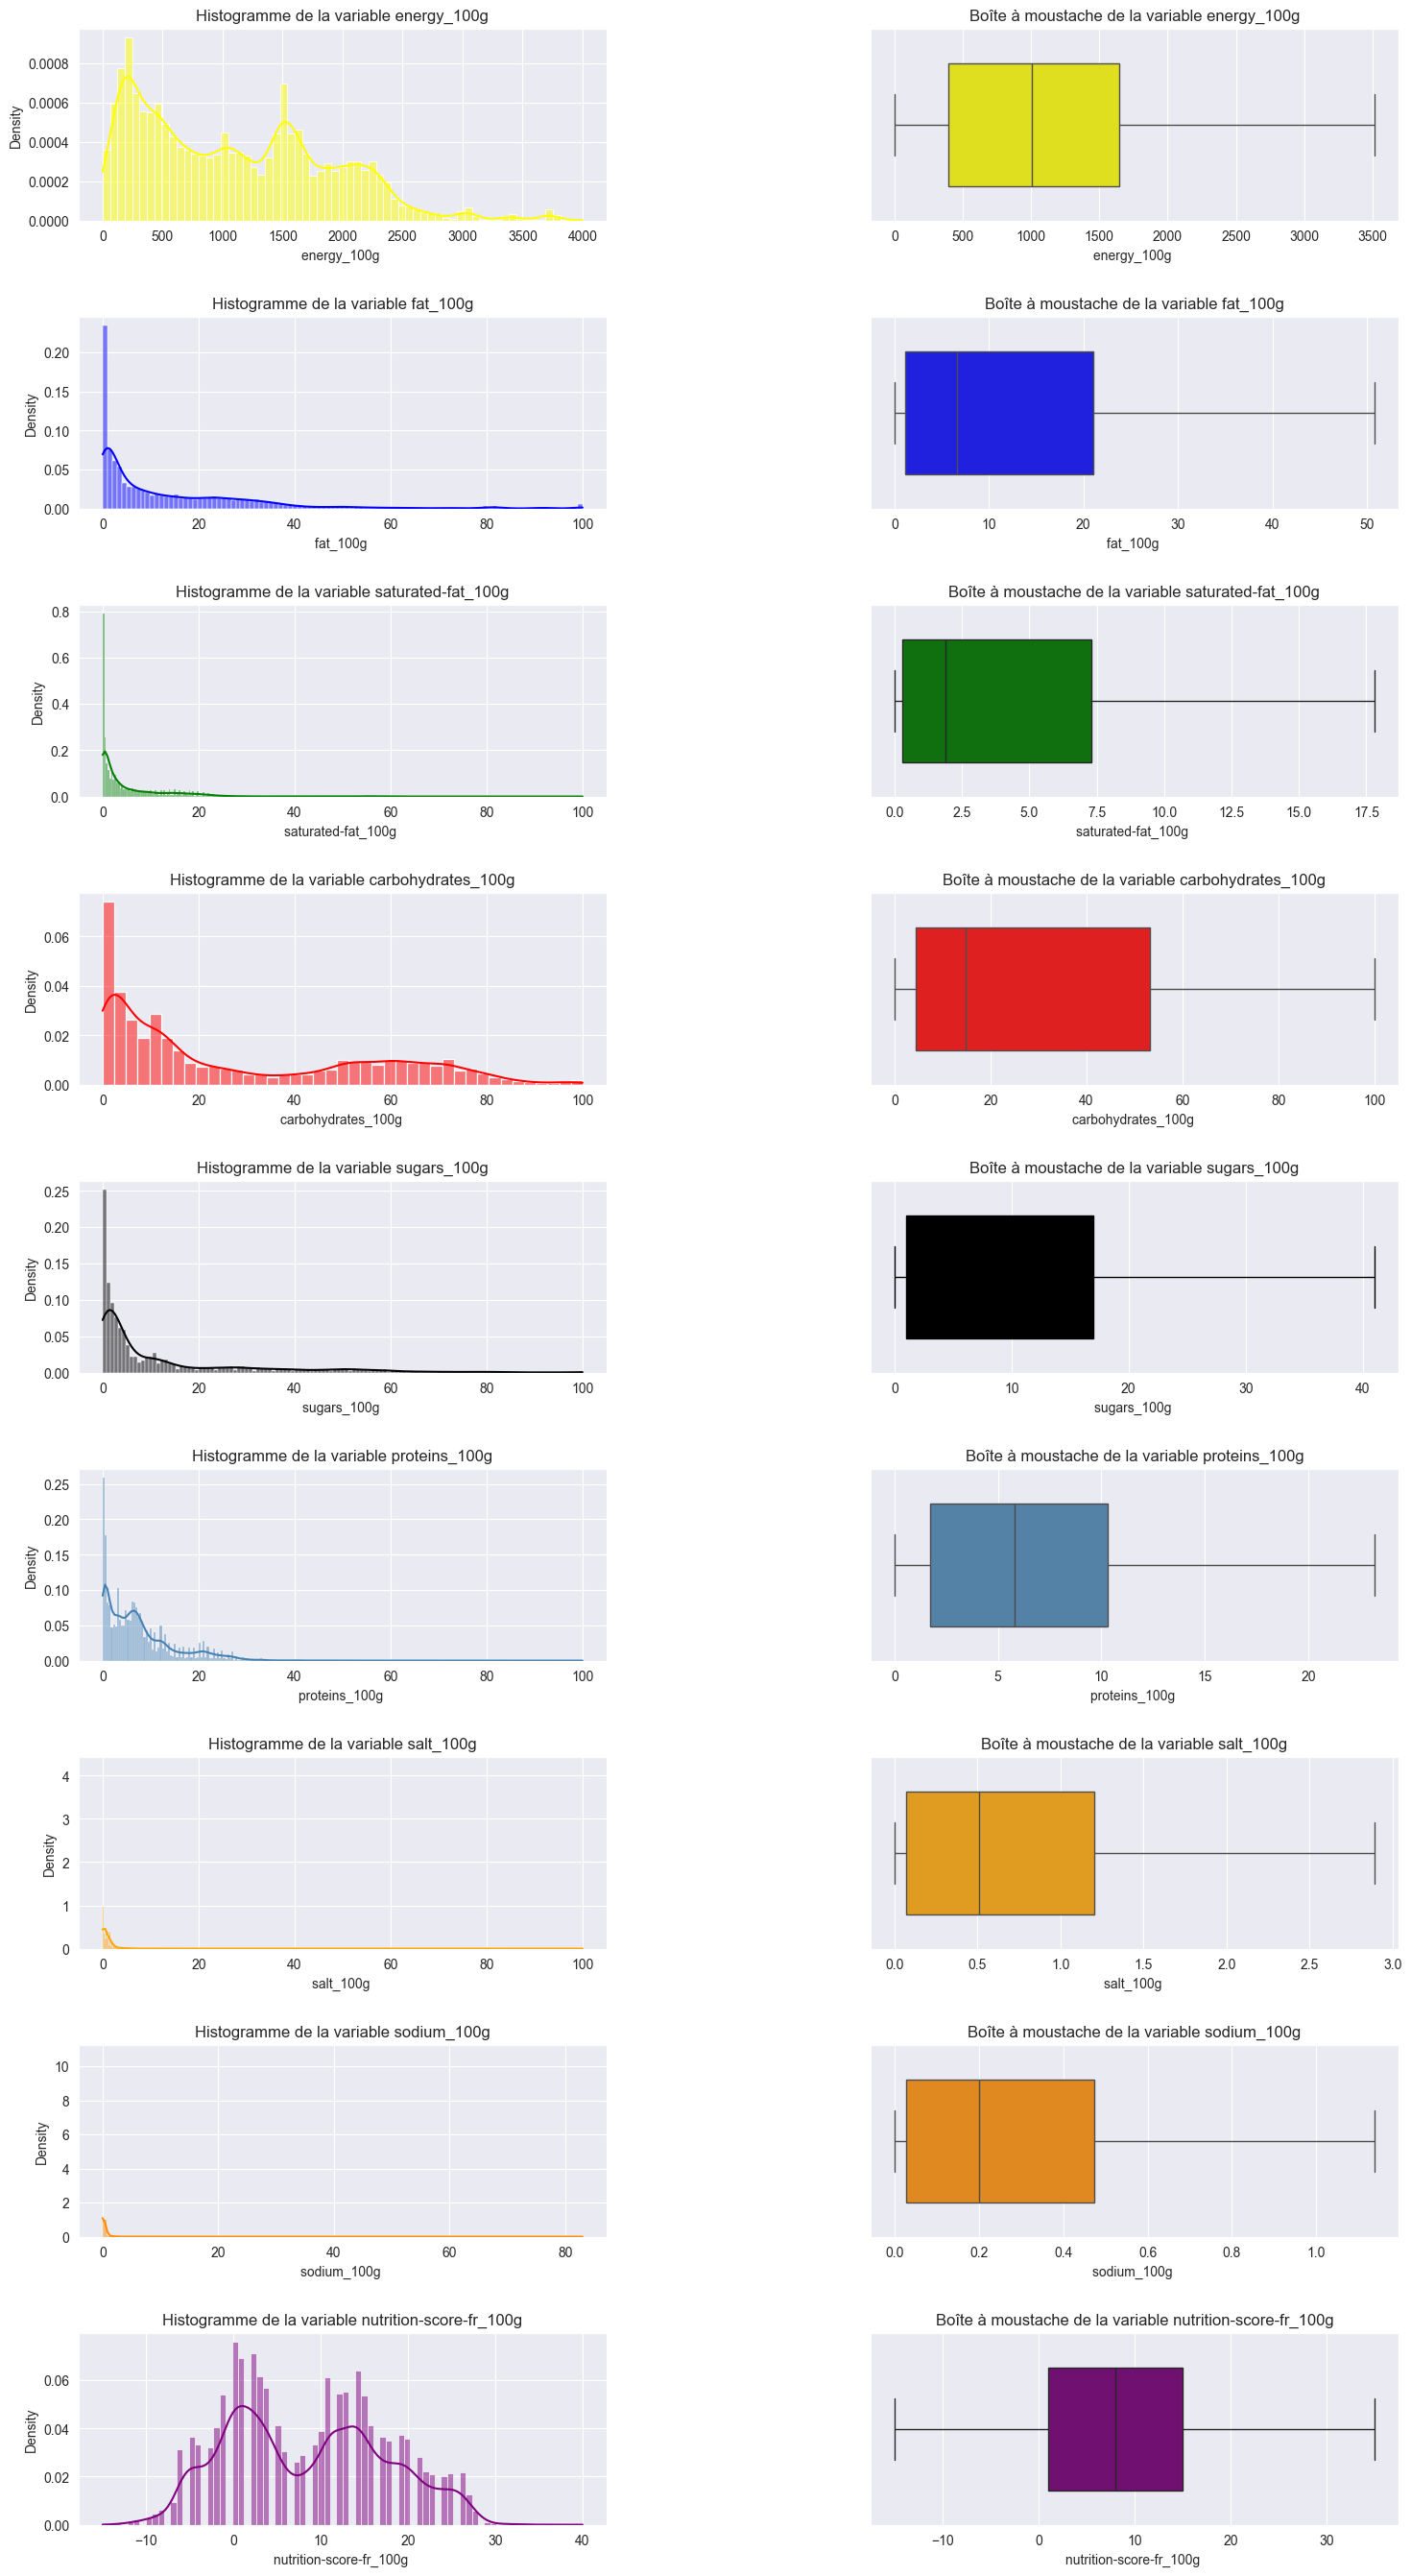

In [36]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',3),('saturated-fat_100g','green',5),('carbohydrates_100g','red',7),('sugars_100g','black',9),('proteins_100g','steelblue',11),('salt_100g','orange',13),('sodium_100g','darkorange',15),('nutrition-score-fr_100g','purple',17)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 20))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(9, 2, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density")
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

    place=place+1
    # Création des boîtes à moustaches
    axes = figure.add_subplot(9, 2, place)
    sns.boxplot(data=data_clean,x=variable, ax=axes,gap=0.2,legend=False, color=color, showfliers=False)
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")


Visualisons les également à l'échelle logarithmique pour mieux visualiser la distribution :

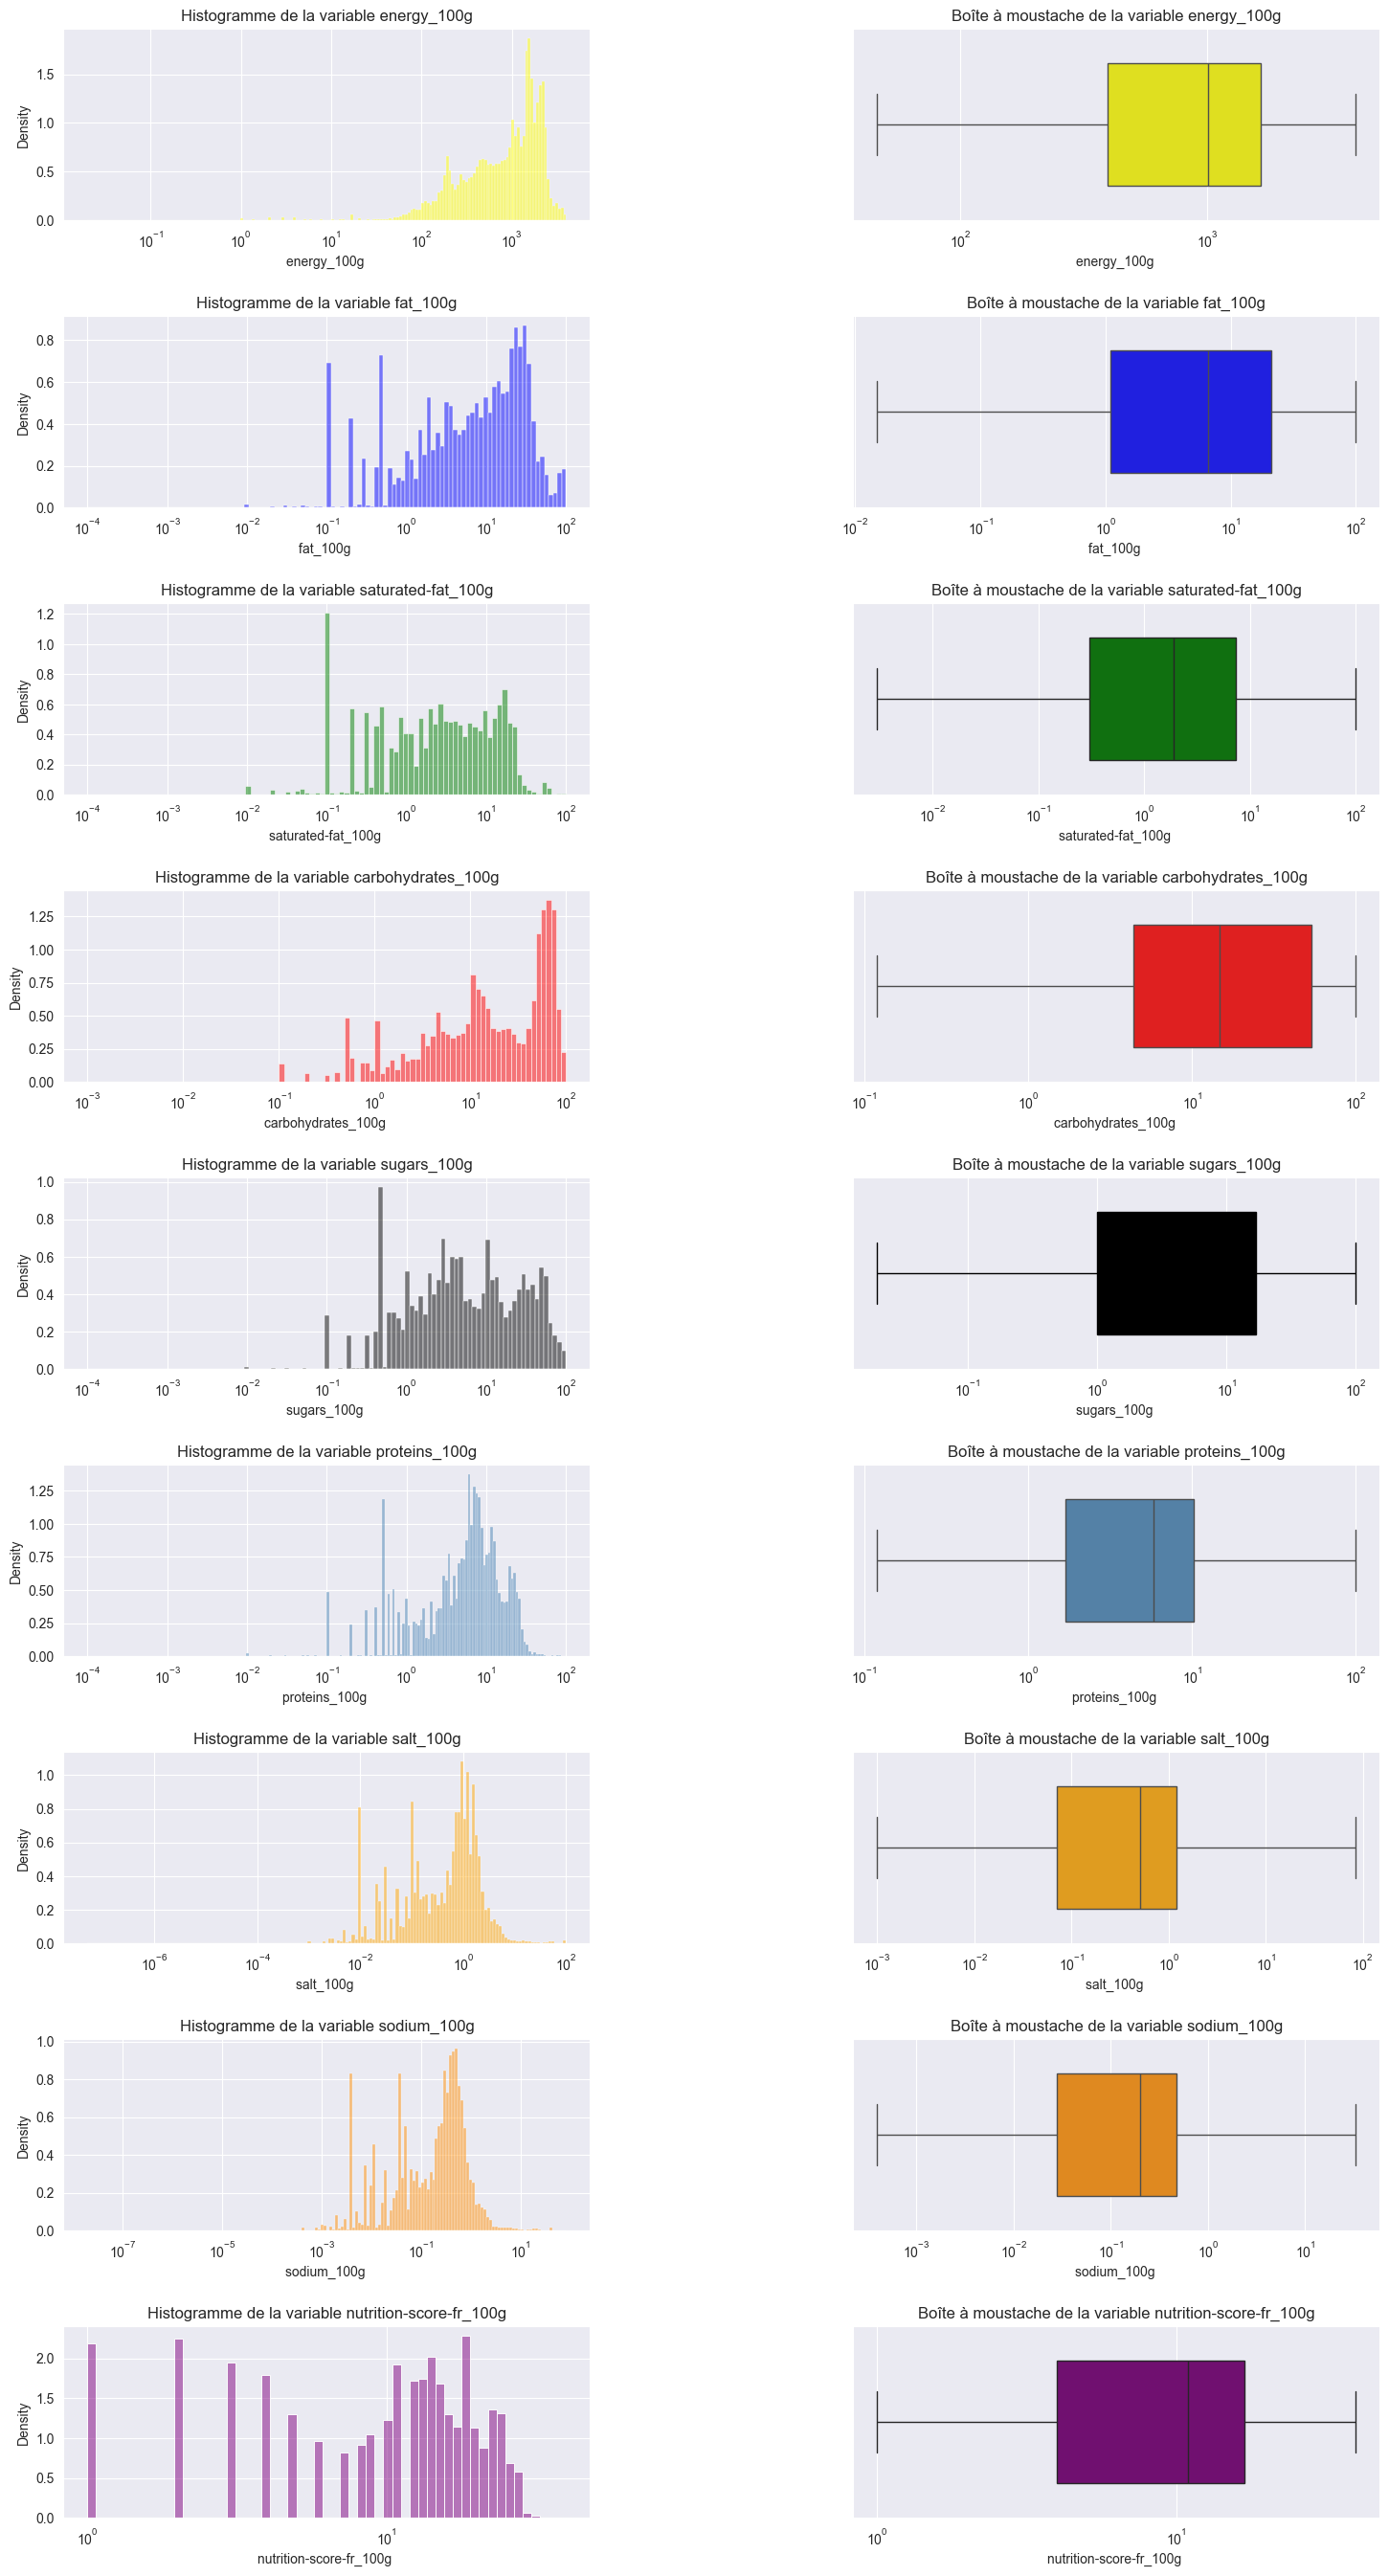

In [37]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',3),('saturated-fat_100g','green',5),('carbohydrates_100g','red',7),('sugars_100g','black',9),('proteins_100g','steelblue',11),('salt_100g','orange',13),('sodium_100g','darkorange',15),('nutrition-score-fr_100g','purple',17)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 20))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(9, 2, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

    place=place+1
    # Création des boîtes à moustaches
    axes = figure.add_subplot(9, 2, place)
    sns.boxplot(data=data_clean,x=variable, ax=axes,gap=0.2,legend=False, color=color, showfliers=False, log_scale=True)
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")


Passons à des analyses bivariées sur ces données et construisons maintenant la matrice de corrélations pour définir des relations entre les variables :

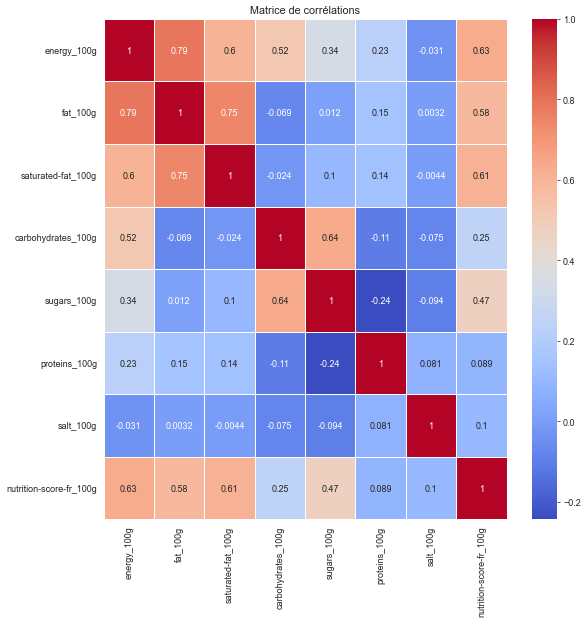

In [191]:
data_quant=col_quant(data_clean)
corr=data_quant.corr()
fig = plt.figure(figsize=(10,10), dpi = 65)
sns.heatmap(corr,cmap='coolwarm',annot=True,linewidth=0.9)
plt.title("Matrice de corrélations")
plt.show()

Nous observons :
 - une corrélation parfaite entre le sel et le sodium qui était attendue, l'analyse d'une seule de ces variables sera pertinente
 - les graisses sont fortement corrélées entre elles  et également corrélées au nutriscore et à l'énergie
 - le sucre et les carbohydrates sont fortement corrélés entre eux
 - le sucre est légèrement corrélé au nutriscore et les carbohydrates à l'énergie
 - Aucune anti-corrélation prononcée n'apparait

Si nous nous concentrons uniquement sur ces variables :

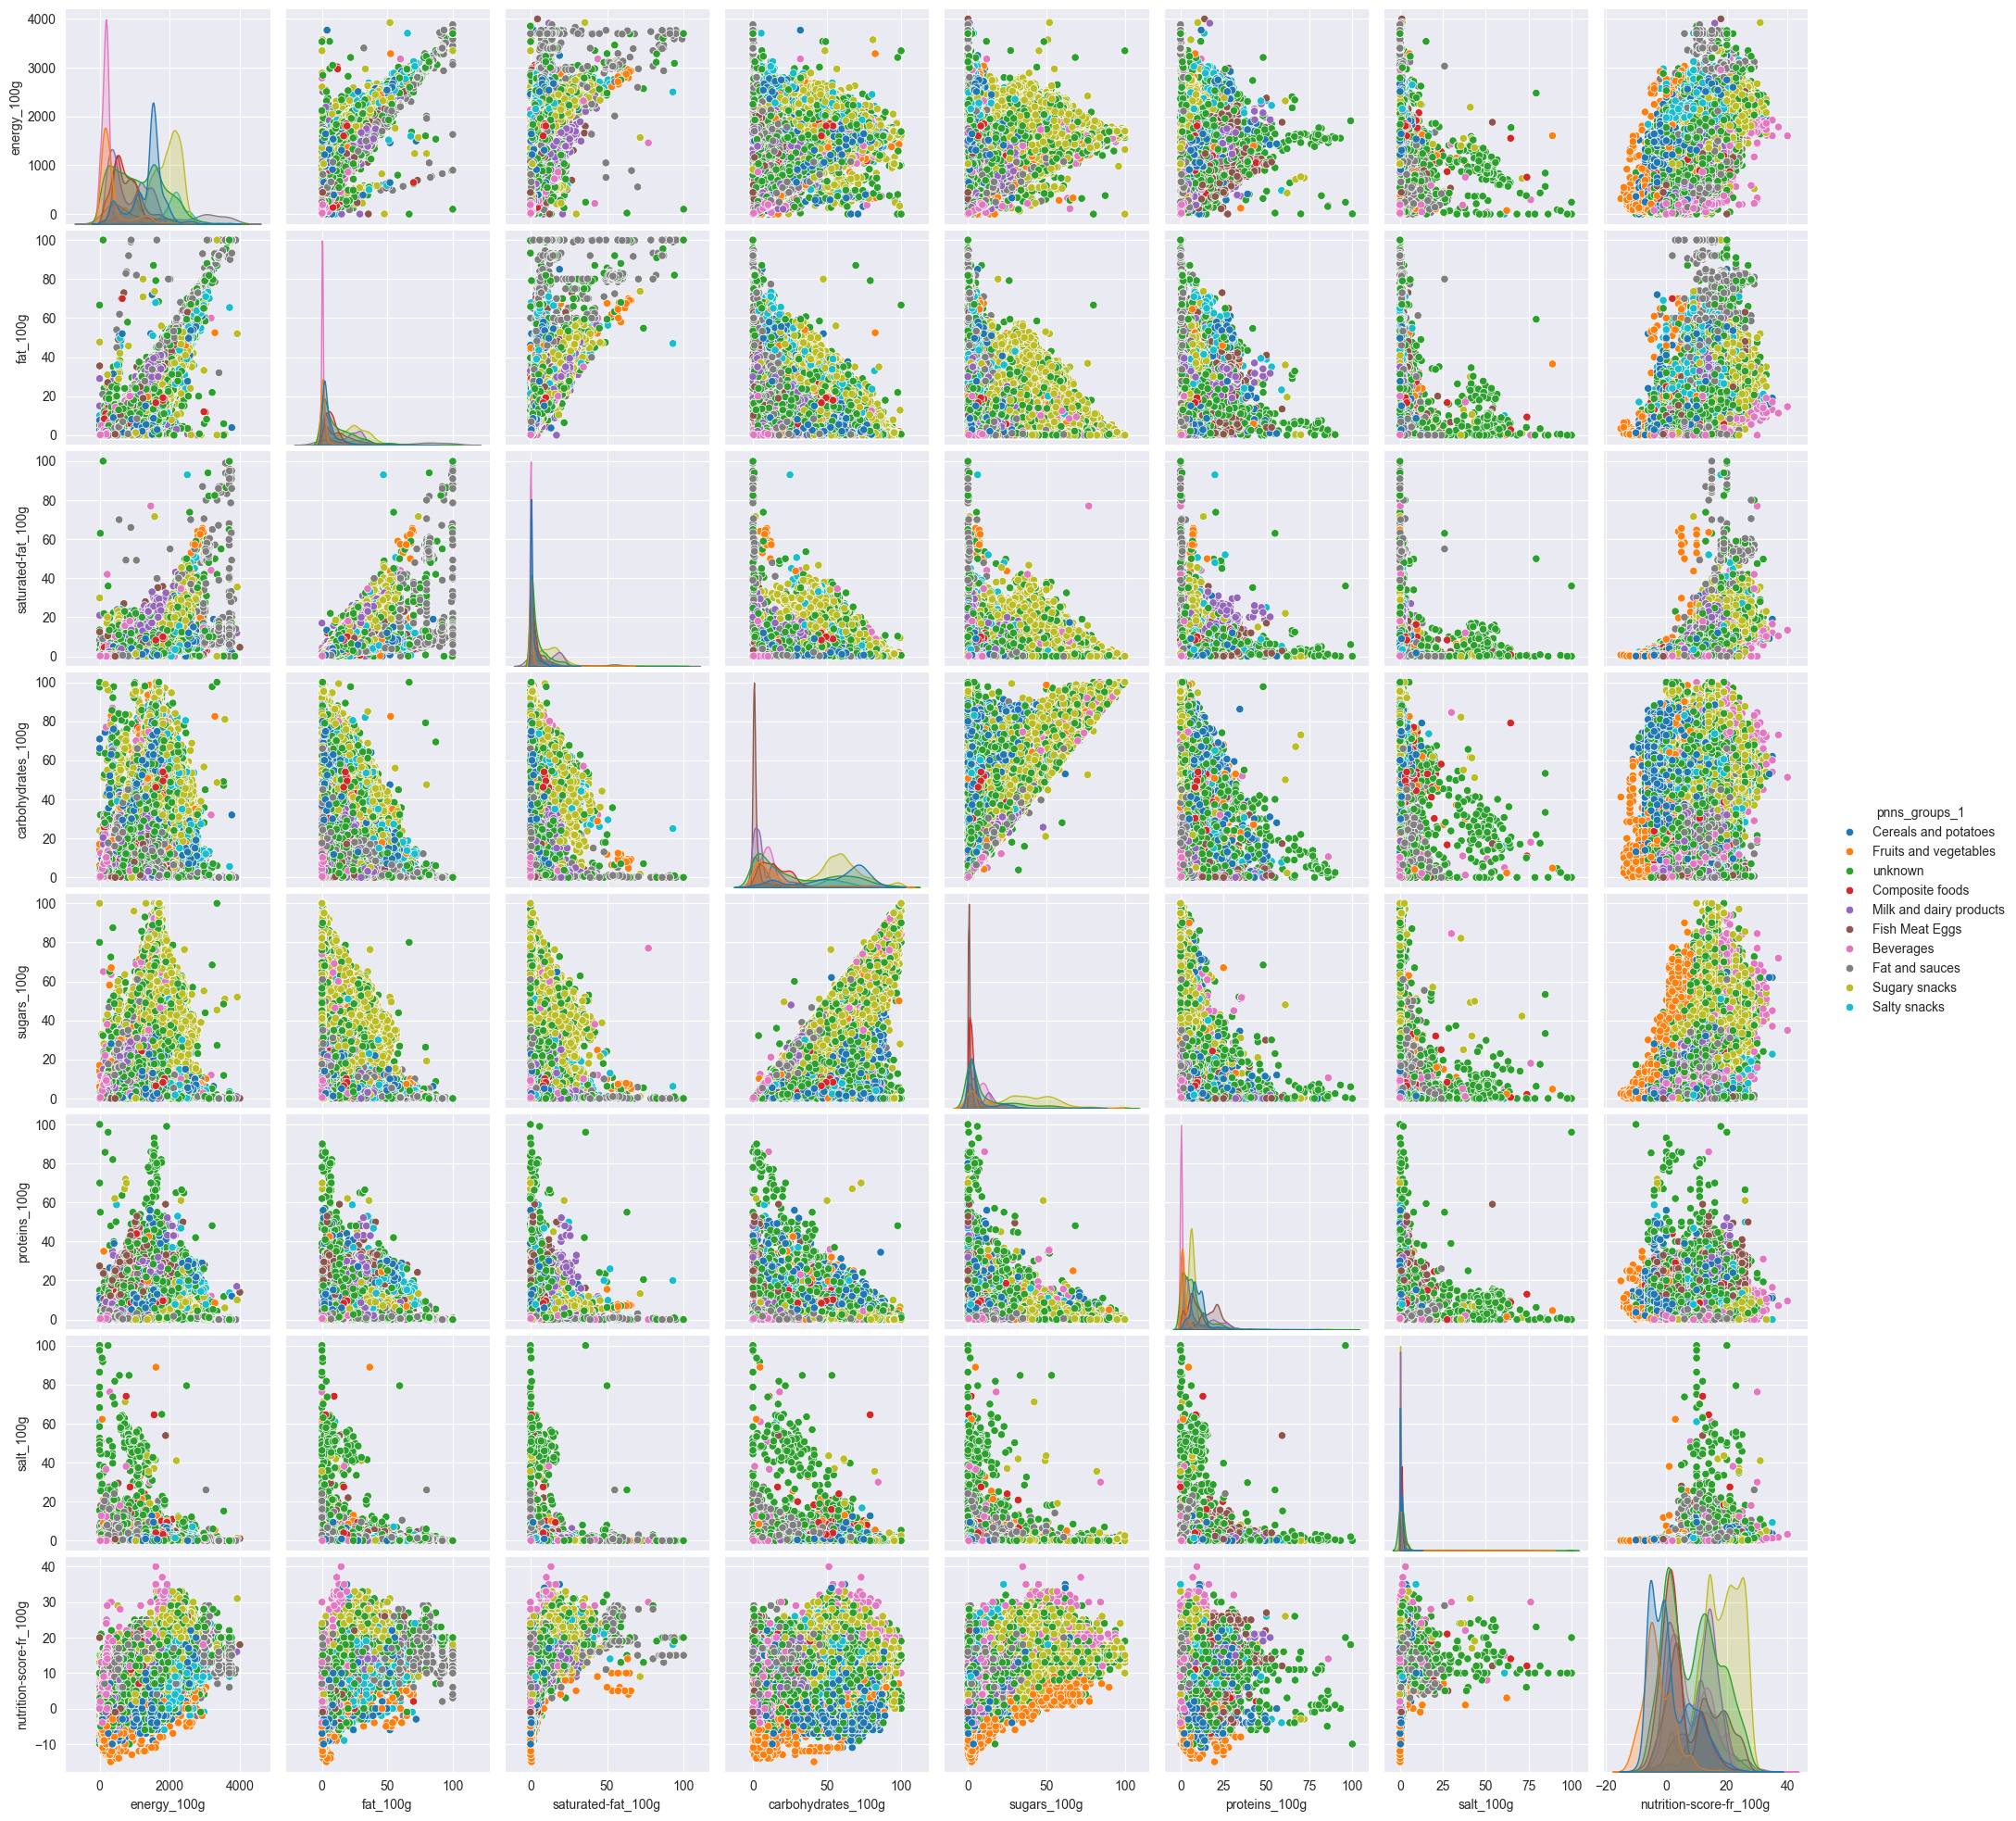

<Figure size 2192.88x2000 with 0 Axes>

In [39]:
variable=['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g','pnns_groups_1']
hue_order =nutriscore_order['pnns_groups_1']
data_quant_corr = data_clean[variable]
# Analyse mutivariée via la méthode pairplot
sns_plot = sns.pairplot(data_quant_corr, hue="pnns_groups_1",hue_order=hue_order)
sns_plot.savefig("pairplot.png")
plt.clf() # Clean pairplot figure
Image(filename='pairplot.png') # Création de l'image PNG

On retrouve les résultats de la matrice de corrélations.

En les traçant en fonction du pnns_groups_1, on voit que les légumes sont plus facilement localisés sur un nutriscore bas ainsi que des valeurs basses de sel, sucre, graisses...

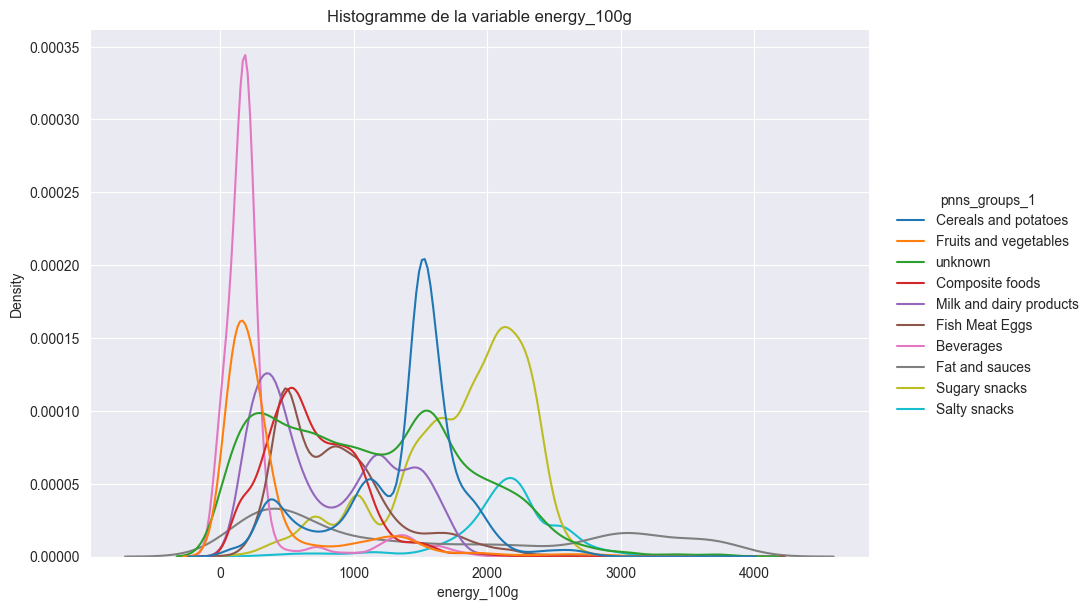

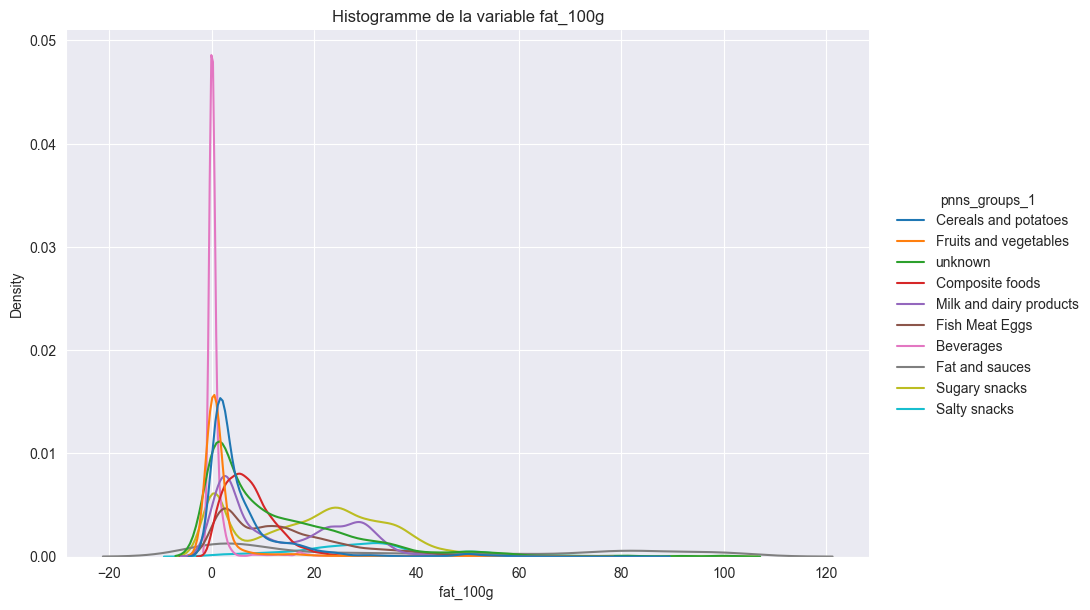

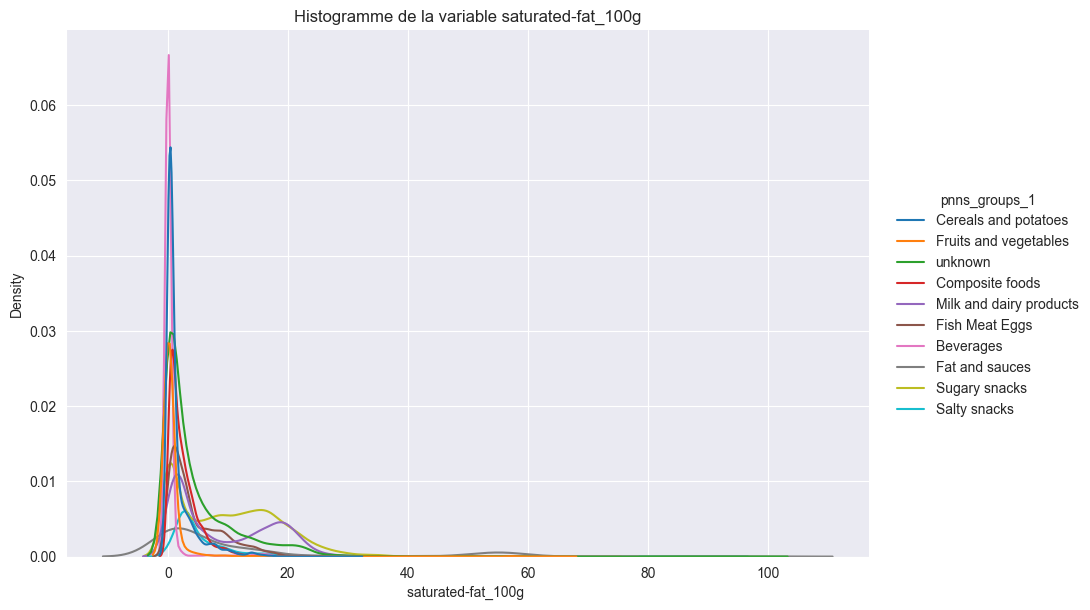

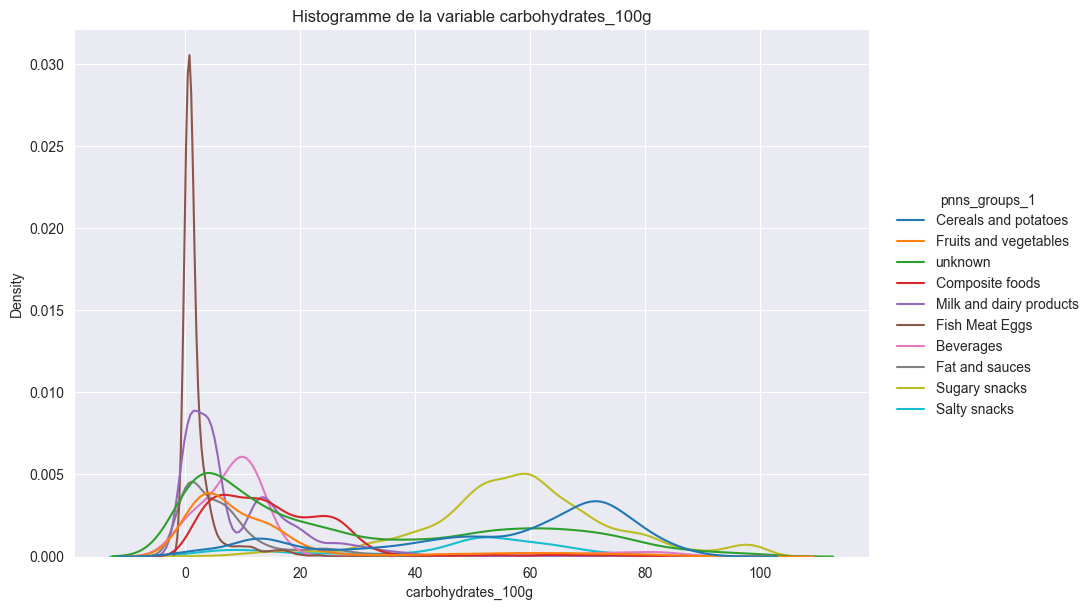

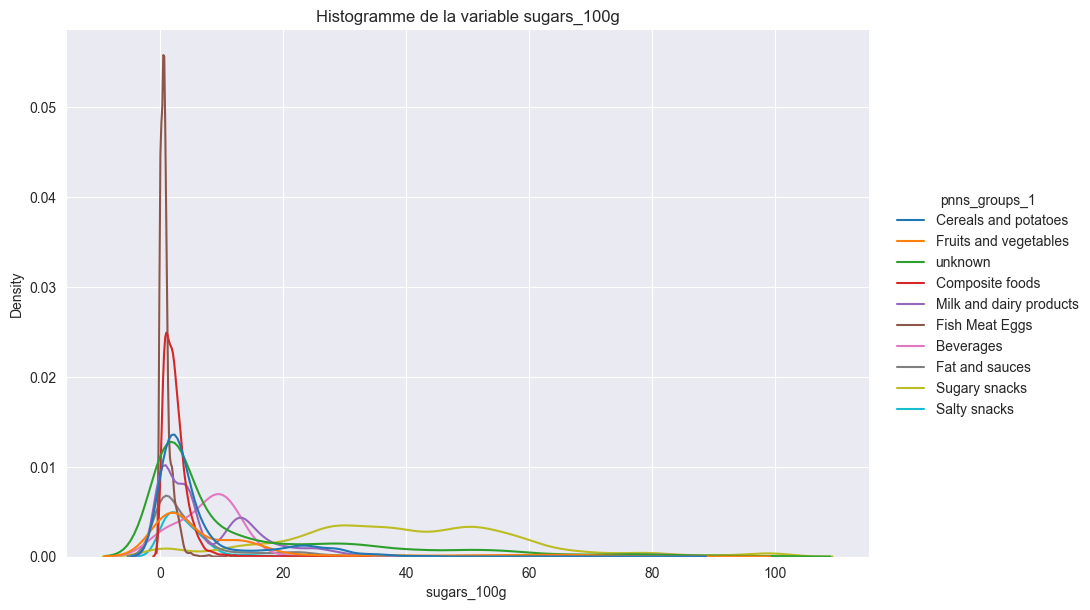

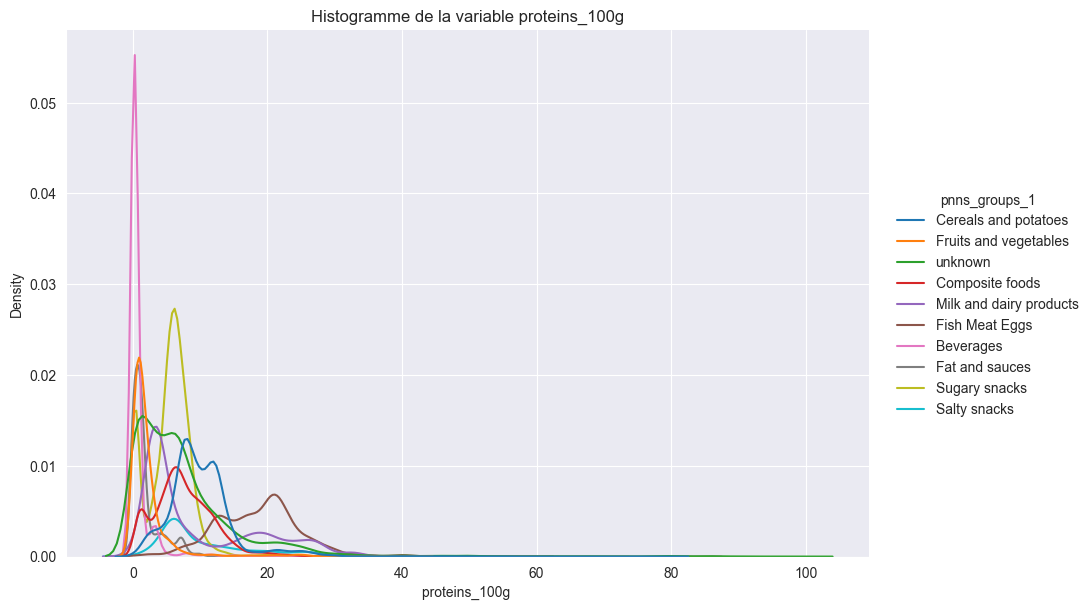

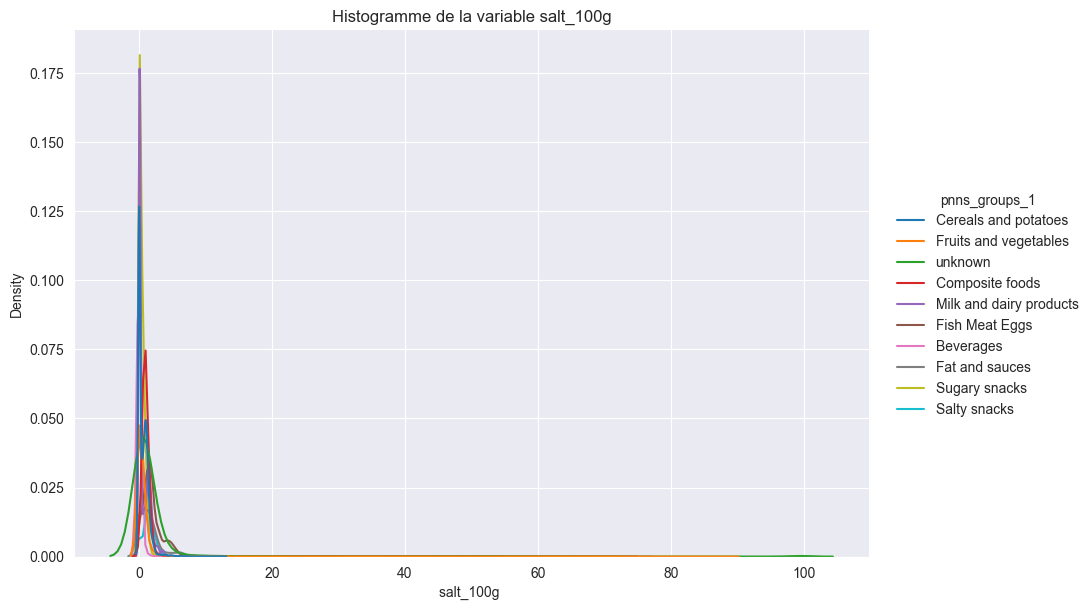

<Figure size 2500x2500 with 0 Axes>

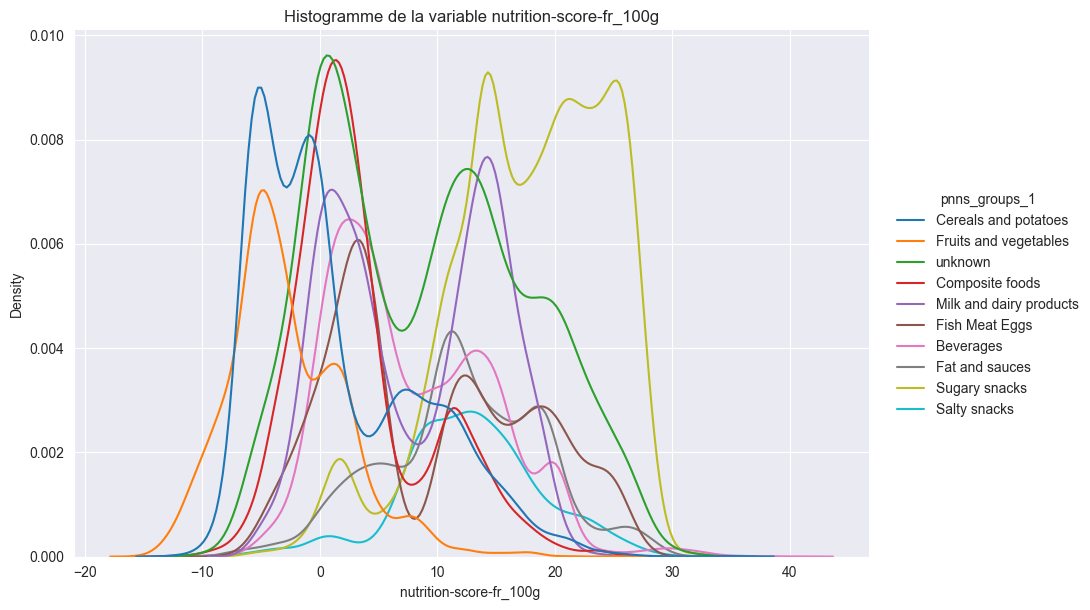

In [131]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('carbohydrates_100g','red',4),('sugars_100g','black',5),('proteins_100g','steelblue',6),('salt_100g','orange',7),('nutrition-score-fr_100g','purple',8)]
hue_order =nutriscore_order['pnns_groups_1']

# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(25, 25))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    sns.displot(data=data_clean, x=variable, hue="pnns_groups_1", kind="kde",  hue_order=hue_order,height=6, aspect=1.5) 
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


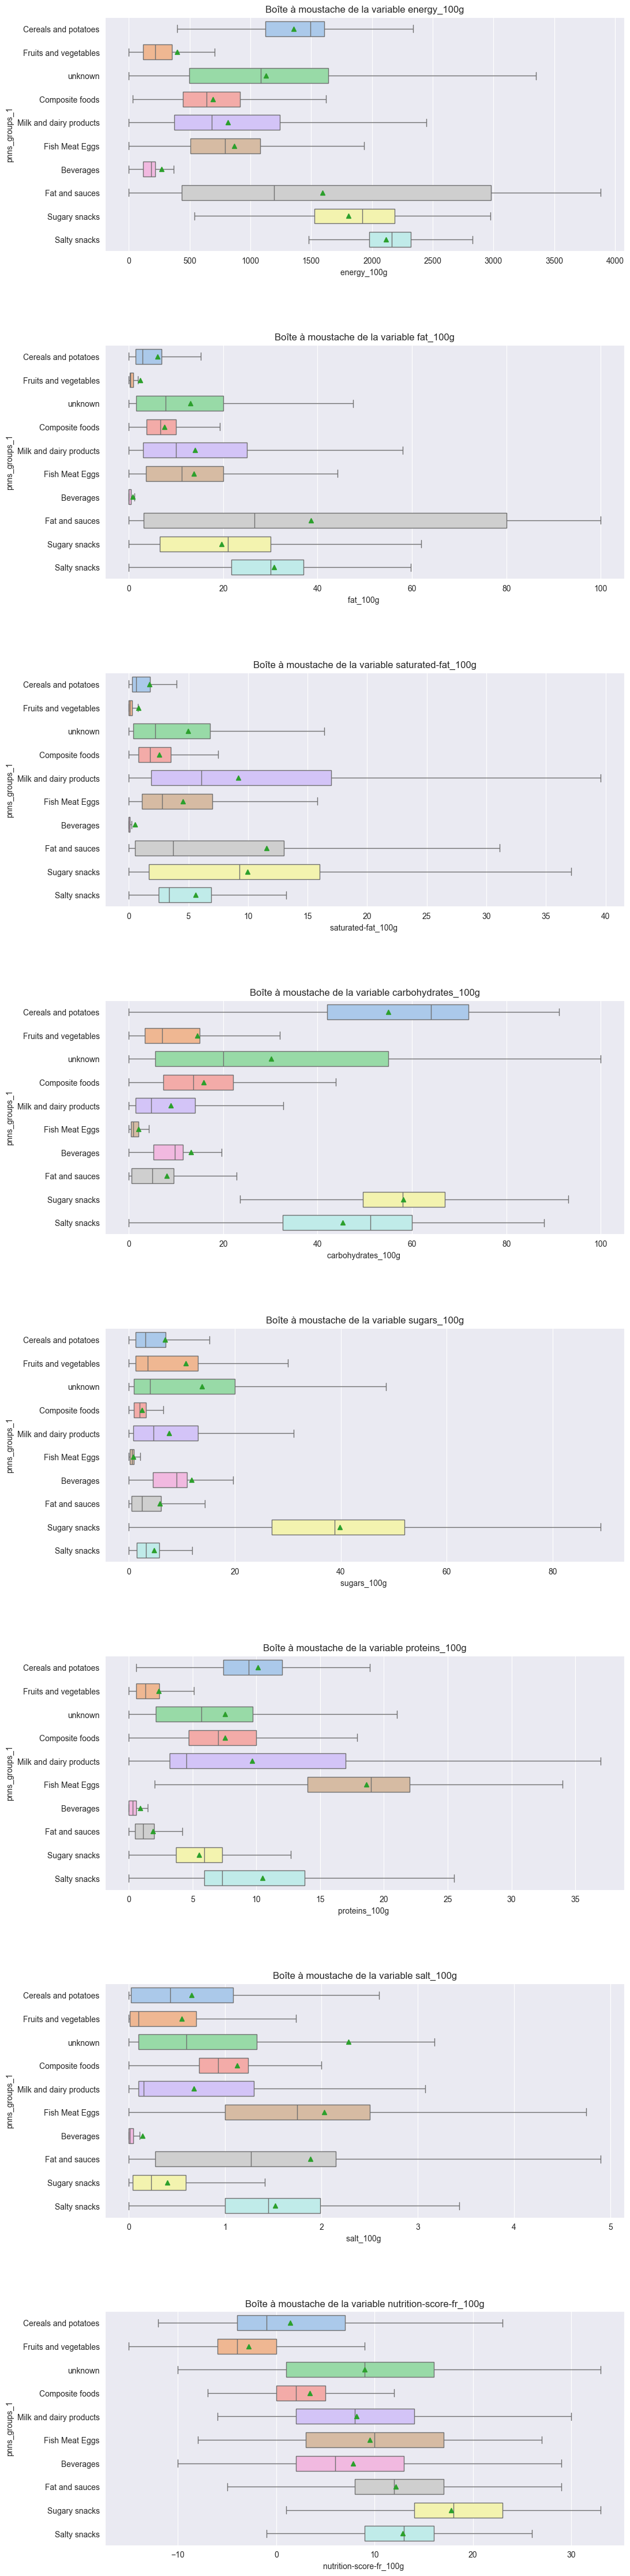

In [132]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('carbohydrates_100g','red',4),('sugars_100g','black',5),('proteins_100g','steelblue',6),('salt_100g','orange',7),('nutrition-score-fr_100g','purple',8)]
hue_order =nutriscore_order['pnns_groups_1']

# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10,10))
    plt.gcf().subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=5, hspace=0.4, wspace=0.3)

    # Création des boîtes à moustaches
    axes = figure.add_subplot(9, 1, place)
    sns.boxplot(data=data_clean,x=variable, y=data_clean["pnns_groups_1"], ax=axes, gap=0.2,legend=True,order=hue_order, showfliers=False,showmeans=True, palette='pastel')
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")

Il n'y a pas vraiment de surprises sur les résultats, on retrouve les catégories salées, sucrées et grasses avec des médianes de nutriscore les plus hauts, à l'opposé des fruits et légumes.

On observe une différence significative de la moyenne (triangles verts) de toutes les variables au sein des groupes pnns_1. 
On peut penser qu’une dépendance existe entre ces variables et « pnns_groups_1 ».


## Test statistique (pnns1 vs nutrition score)

### ANOVA  (qualitative vs quantitative)


On souhaite effectuer une analyse de variance pour mesurer l’indépendance entre une variable qualitative (pnns1) et une quantitative (nutriscore).

Partons sur un test paramétrique permettant d'étudier l'indépendance d'une variable qualitative vs quantitative : l'ANOVA. En effet, un test paramétrique est plus puissant qu'un test non-paramétrique mais impose des contraintes sur la distribution des données.

La première étape est donc d'analyser l'homogénéisation des variances : si elles sont égales, nous pourrons effectuer une ANOVA, sinon nous ferons une ANOVA de Welch plus pertinente dans ce cas précis.

On s'interesse au variance de chaque groupe. Le test de Levene permet de tester si les variances sont significativement différentes ou non pour des variables qui n'ont pas de distribution normale (contrairement au test de Bartlett). 


In [118]:
# Test statistique de Levene pour valider ou infirmer l'homogénéisation de la variance entre les groupes

data_levene=[data_clean[data_clean['pnns_groups_1']=='Beverages']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Cereals and potatoes']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Composite foods']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Fat and sauces']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Fish Meat Eggs']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Fruits and vegetables']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Milk and dairy products']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Salty snacks']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Sugary snacks']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='unknown']['nutrition-score-fr_100g'].sample(2500)]
test_stat, p_value = levene(data_levene[0], data_levene[1], data_levene[2], data_levene[3], data_levene[4], data_levene[5], data_levene[6], data_levene[7], data_levene[8], data_levene[9],nan_policy='omit')
print(test_stat, p_value)

156.74244189442882 5.353009063025445e-287


Les résultats du test de Levene indique qu'il n'y a pas d'homogénéité de la variance entre les groupes (p-value <0.05 donc hypothèse de l'homogénéité de la variance rejetée).

Dans ce cas, faisons une ANOVA de Welch pour compenser cette absence d'homogénéité :

In [119]:
data_welch=[]
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Beverages']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Cereals and potatoes']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Composite foods']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Fat and sauces']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Fish Meat Eggs']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Fruits and vegetables']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Milk and dairy products']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Salty snacks']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Sugary snacks']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='unknown']['nutrition-score-fr_100g'].sample(2500))

df = pd.DataFrame({'score': data_welch,
                   'group': np.repeat(['Beverages', 'Cereals and potatoes', 'Composite foods','Fat and sauces','Fish Meat Eggs','Fruits and vegetables','Milk and dairy products','Salty snacks',
                                      'Sugary snacks','unknown'], repeats=2500)}) 
aov = welch_anova(dv='score', between='group', data=df)
aov

Source  ddof1        ddof2            F  p-unc     np2
0  group      9  7250.614847  1899.246533    0.0  0.4142

p-value = 0 < 0.05 ce qui signifie que nous pouvons rejeter l’hypothèse nulle selon laquelle la moyenne du nutriscore est égale entre les différents groupes pnns.
Nous pouvons ensuite effectuer le test post-hoc de Games-Howell (cas de variances inégales donc d'ANOVA de Welch) pour déterminer exactement quelles moyennes de groupe sont différentes :

In [44]:
test_gh=pg.pairwise_gameshowell(dv='score', between='group', data=df)
pg.pairwise_gameshowell(dv='score', between='group', data=df)

A                        B    mean(A)    mean(B)  \
0                 Beverages     Cereals and potatoes   7.763770   1.245605   
1                 Beverages          Composite foods   7.763770   3.462601   
2                 Beverages           Fat and sauces   7.763770  12.181072   
3                 Beverages           Fish Meat Eggs   7.763770   9.652122   
4                 Beverages    Fruits and vegetables   7.763770  -2.715432   
5                 Beverages  Milk and dairy products   7.763770   8.372599   
6                 Beverages             Salty snacks   7.763770  12.835222   
7                 Beverages            Sugary snacks   7.763770  17.891184   
8                 Beverages                  unknown   7.763770   8.661372   
9      Cereals and potatoes          Composite foods   1.245605   3.462601   
10     Cereals and potatoes           Fat and sauces   1.245605  12.181072   
11     Cereals and potatoes           Fish Meat Eggs   1.245605   9.652122   
12     Cereals and potatoes    Fruits and vegetables   1.245605  -2.715432   
13     Cereals and potatoes  Milk and dairy products   1.245605   8.372599   
14     Cereals and potatoes             Salty snacks   1.245605  12.835222   
15     Cereals and potatoes            Sugary snacks   1.245605  17.891184   
16     Cereals and potatoes                  unknown   1.245605   8.661372   
17          Composite foods           Fat and sauces   3.462601  12.181072   
18          Composite foods           Fish Meat Eggs   3.462601   9.652122   
19          Composite foods    Fruits and vegetables   3.462601  -2.715432   
20          Composite foods  Milk and dairy products   3.462601   8.372599   
21          Composite foods             Salty snacks   3.462601  12.835222   
22          Composite foods            Sugary snacks   3.462601  17.891184   
23          Composite foods                  unknown   3.462601   8.661372   
24           Fat and sauces           Fish Meat Eggs  12.181072   9.652122   
25           Fat and sauces    Fruits and vegetables  12.181072  -2.715432   
26           Fat and sauces  Milk and dairy products  12.181072   8.372599   
27           Fat and sauces             Salty snacks  12.181072  12.835222   
28           Fat and sauces            Sugary snacks  12.181072  17.891184   
29           Fat and sauces                  unknown  12.181072   8.661372   
30           Fish Meat Eggs    Fruits and vegetables   9.652122  -2.715432   
31           Fish Meat Eggs  Milk and dairy products   9.652122   8.372599   
32           Fish Meat Eggs             Salty snacks   9.652122  12.835222   
33           Fish Meat Eggs            Sugary snacks   9.652122  17.891184   
34           Fish Meat Eggs                  unknown   9.652122   8.661372   
35    Fruits and vegetables  Milk and dairy products  -2.715432   8.372599   
36    Fruits and vegetables             Salty snacks  -2.715432  12.835222   
37    Fruits and vegetables            Sugary snacks  -2.715432  17.891184   
38    Fruits and vegetables                  unknown  -2.715432   8.661372   
39  Milk and dairy products             Salty snacks   8.372599  12.835222   
40  Milk and dairy products            Sugary snacks   8.372599  17.891184   
41  Milk and dairy products                  unknown   8.372599   8.661372   
42             Salty snacks            Sugary snacks  12.835222  17.891184   
43             Salty snacks                  unknown  12.835222   8.661372   
44            Sugary snacks                  unknown  17.891184   8.661372   

         diff        se           T           df          pval    hedges  
0    6.518164  0.228695   28.501582  3479.257565  3.212985e-12  0.946699  
1    4.301169  0.212312   20.258764  3138.002917  0.000000e+00  0.684181  
2   -4.417302  0.233470  -18.920236  3396.376341  4.373168e-13 -0.644885  
3   -1.888352  0.270136   -6.990375  3200.089801  1.500167e-10 -0.242493  
4   10.479202  0.211652   49.511501  2965.968294  0.000000e+00

Avec les p-values <0.05 on voit que toutes ces paires de groupe pnns ont une différence moyenne significativement différente vis à vis du nutriscore. Voici celles qui ne le sont pas :

In [45]:
test_gh_ns=test_gh.loc[test_gh['pval']>0.05]
test_gh_ns.head(45)

A                        B   mean(A)   mean(B)  \
5                 Beverages  Milk and dairy products  7.763770  8.372599   
8                 Beverages                  unknown  7.763770  8.661372   
34           Fish Meat Eggs                  unknown  9.652122  8.661372   
41  Milk and dairy products                  unknown  8.372599  8.661372   

        diff        se         T           df      pval    hedges  
5  -0.608829  0.229127 -2.657170  3445.907093  0.191847 -0.089039  
8  -0.897602  0.290758 -3.087114  2623.766969  0.063182 -0.114853  
34  0.990750  0.314027  3.154984  2923.990120  0.051701  0.114840  
41 -0.288773  0.279533 -1.033057  2480.404921  0.990261 -0.037832

Les variables "boissons" et "produits laitiers" ont donc une différence moyenne non significative vis à vis du nutriscore que ce soit entre elles ou avec le groupe "inconnu". De même pour la paire de groupes "poissons,viandes,oeufs" et "inconnu" .

Maintenant pour vérifier si les résultats de cette ANOVA de Welch peuvent être interprétables, vérifions les deux conditions essentielles : la normalité  et l'homogénéisation de la variance des résidus (les écarts entre les valeurs observées et les valeurs estimées par un modèle : ici la régression linéaire avec l'ANOVA).

Commençons par la normalité des résidus :

In [121]:
df=data_clean.rename(columns={'nutrition-score-fr_100g': 'nutriscore'})
print(df.columns)

Index(['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2',
       'main_category_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutriscore'],
      dtype='object')


In [122]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'nutriscore  ~ pnns_groups_1'

model = ols(formula, data=df).fit()
res = model.resid

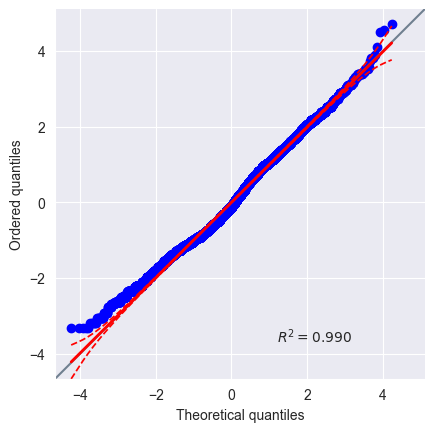

In [123]:
# QQ plot
ax = pg.qqplot(res, dist='norm')
sns.despine()

In [124]:
#Test de Shapiro-Wilk 
pg.normality(res)


W          pval  normal
0  0.990451  7.449901e-50   False

La p-value est inférieure à 0.05, l'hypothèse H0 est donc rejetée ce qui signifie que la distribution des résidus n'est pas normale. Testons maintenant l'homogénéité des variances des résidus :

In [125]:
res_groupe ={}
for groupe in df['pnns_groups_1'].unique():
    residu_gr=res[df['pnns_groups_1']==groupe]
    res_groupe[groupe]=residu_gr

In [126]:
# Test de Levene pour l'homogénéité des variances
levene_test=levene(*res_groupe.values())
print(levene_test.pvalue)

0.0


##### La p-value est inférieure à 0.05, l'hypothèse H0 est donc rejetée ce qui signifie que les variances des résidus ne sont pas homogènes.
Les deux conditions n'étant pas satisfaites, les résultats de l'ANOVA ne sont pas interprétables.

## Test de Kruskal-Wallis (comparaison de moyenne entre variable quantitative vs qualitative)

Dans ce cas nous pouvons effectuer un test non-paramètrique (c'est à dire sans condition sur la distribution des données) : le test de somme des rangs de Kruskal-Wallis.

In [127]:
data_kw=[]
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Beverages']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Cereals and potatoes']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Composite foods']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Fat and sauces']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Fish Meat Eggs']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Fruits and vegetables']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Milk and dairy products']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Salty snacks']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Sugary snacks']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='unknown']['nutrition-score-fr_100g'].sample(2500))

df = pd.DataFrame({'score': data_kw,
                   'group': np.repeat(['Beverages', 'Cereals and potatoes', 'Composite foods','Fat and sauces','Fish Meat Eggs','Fruits and vegetables','Milk and dairy products','Salty snacks',
                                      'Sugary snacks','unknown'], repeats=2500)}) 

pg.kruskal(data=df, dv='score', between='group').round(3)


Source  ddof1        H  p-unc
Kruskal  group      9  7324.06    0.0

La p-value est inférieure à 0.05, l'hypothèse d'indépendance H0 est donc rejetée ce qui signifie que la différence entre les moyennes des groupes est statistiquement significative, les variables nutriscore et pnns1 sont donc liées, selon le groupe pnns1, le nutriscore varie.

Effectuons le test de Dunn-Bonferroni pour déterminer quelles paires diffèrent :


In [129]:
test_db=sp.posthoc_dunn(df, val_col='score',group_col='group', p_adjust = 'bonferroni')
print(test_db<0.05)

                         Beverages  Cereals and potatoes  Composite foods  \
Beverages                    False                  True             True   
Cereals and potatoes          True                 False             True   
Composite foods               True                  True            False   
Fat and sauces                True                  True             True   
Fish Meat Eggs                True                  True             True   
Fruits and vegetables         True                  True             True   
Milk and dairy products      False                  True             True   
Salty snacks                  True                  True             True   
Sugary snacks                 True                  True             True   
unknown                      False                  True             True   

                         Fat and sauces  Fish Meat Eggs  \
Beverages                          True            True   
Cereals and potatoes              

Avec les p-values <0.05 on voit les paires significativement différentes en terme de moyennes (True) et celles qui ne le sont pas (False) vis à vis du nutriscore. 

Plus précisément, voici celles qui ne diffèrent pas et ont donc une différence non significative en terme de moyenne vis à vis du nutriscore :

- la variable "boissons" n'est pas significativement différente en terme de moyenne comparé aux variables "produits laitiers" et "inconnu".
- la variable "produits laitiers" n'est pas significativement différente en terme de moyenne comparé aux variables "poissons,viandes,oeufs" et "inconnu".
- la variable "poissons,viandes,oeufs" n'est pas significativement différente en terme de moyenne comparé à la variable "inconnu".
- la variable "snacks salés" n'est pas significativement différente en terme de moyenne comparé à la variable "graisses et sauces".

On retrouve celles du test de Games-Howell après l'ANOVA de Welch avec quelques paires en plus. On peut également regarder plus en détail les paires qui ont plus de poids sur ces différences en regardant les valeurs de p-values des paires

In [130]:
print(test_db )

                             Beverages  Cereals and potatoes  Composite foods  \
Beverages                 1.000000e+00          1.248548e-61     6.770351e-29   
Cereals and potatoes      1.248548e-61          1.000000e+00     4.810904e-07   
Composite foods           6.770351e-29          4.810904e-07     1.000000e+00   
Fat and sauces            7.792805e-22         3.562981e-169    4.331009e-110   
Fish Meat Eggs            3.335305e-02          1.321783e-91     2.939192e-50   
Fruits and vegetables    2.586612e-141          5.650839e-22     2.577946e-52   
Milk and dairy products   1.000000e+00          1.605857e-71     2.262385e-34   
Salty snacks              6.858249e-33         1.084325e-207    7.699330e-140   
Sugary snacks            3.318999e-113          0.000000e+00    1.780264e-286   
unknown                   1.000000e+00          8.048630e-67     6.483884e-34   

                         Fat and sauces  Fish Meat Eggs  \
Beverages                  7.792805e-22    3.3353

## Imputation des valeurs manquantes

En terme d'imputation, commençons par supprimer la colonne 'sodium_100g' qui est identique à celle du sel.

Visualisation des pourcentages de valeurs manquantes par variable conservée :

In [135]:
data_clean=data_clean.drop('sodium_100g',axis=1)
data_mv=show_miss_val(data_clean,0)
data_mv.head(20)

variable  miss_val
2             pnns_groups_1  0.000000
3             pnns_groups_2  0.000000
0              product_name  0.011108
4          main_category_fr  0.095591
5               energy_100g  0.227314
10            proteins_100g  0.234619
6                  fat_100g  0.266633
8        carbohydrates_100g  0.271921
11                salt_100g  0.272048
9               sugars_100g  0.275028
7        saturated-fat_100g  0.278403
1        nutrition_grade_fr  0.295691
12  nutrition-score-fr_100g  0.295691

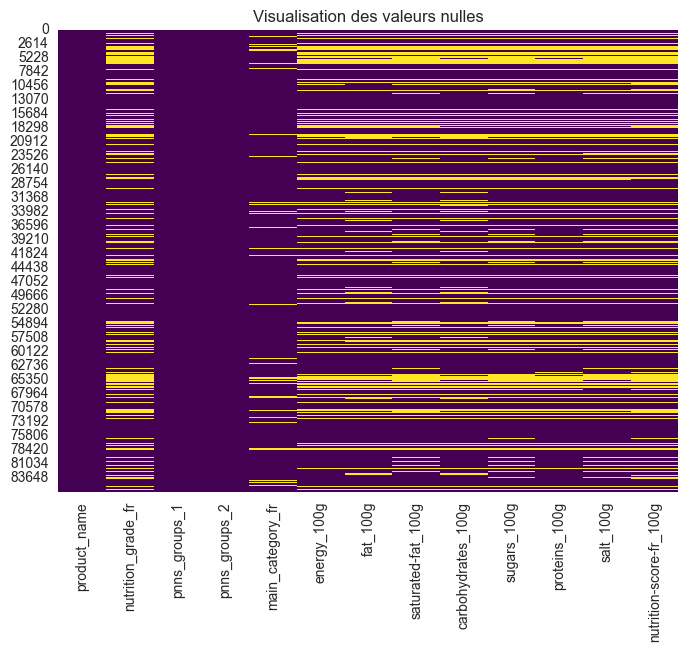

In [136]:
# Visualiser les valeurs nulles
mask = data_clean.isnull()

# Tracer le graphique
plt.figure(figsize=(8, 6))
sns.heatmap(mask, cmap='viridis', cbar=False)
plt.title('Visualisation des valeurs nulles')
plt.show()

### Par la médiane

Les variables "salt_100g" et "proteins_100g" ne sont pas corrélées avec d'autres variables, nous allons donc faire une imputation des valeurs manquantes par la médiane pour ces variables, en fonction de chaque groupe pnns1.

Vérifions les distributions des variables avant l'imputation afin de pouvoir les comparer avec celles d'après :

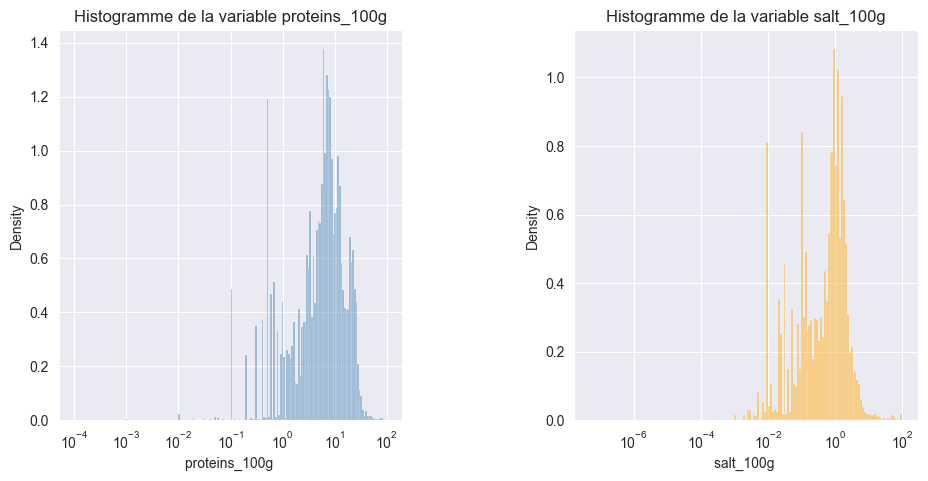

In [58]:
# Liste des variables à visualiser et leurs informations associées
variables=[('proteins_100g','steelblue',1),('salt_100g','orange',2)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(1, 3, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


Calculons les médianes de ces deux variables par groupe pnnns1 et imputons :

In [59]:
# Imputation des variables protéines et sel par la médiane
variables=[('proteins_100g'),('salt_100g')]
for i in variables:
    data_clean[i] = data_clean[i].fillna(data_clean.groupby('pnns_groups_1')[i].transform('median'))
data_clean.head(10)

product_name nutrition_grade_fr          pnns_groups_1  \
0                   Filet de bœuf                NaN                unknown   
1                  Lion Peanut x2                  e                unknown   
2                         Twix x2                NaN                unknown   
3                  Pack de 2 Twix                NaN                unknown   
4                    Salade Cesar                  c  Fruits and vegetables   
5  Danoises à la cannelle roulées                NaN          Sugary snacks   
6                           Flute                NaN   Cereals and potatoes   
7    Chaussons tressés aux pommes                  c          Sugary snacks   
8             Pain Burger Artisan                  b                unknown   
9               lentilles vertes                 NaN   Cereals and potatoes   

        pnns_groups_2                         main_category_fr  energy_100g  \
0             unknown                           Filet-de-boeuf          NaN   
1             unknown                                      NaN       1883.0   
2             unknown                                      NaN          NaN   
3             unknown                                      NaN       1481.0   
4          Vegetables                            Légumes frais       1210.0   
5  Biscuits and cakes                              Pâtisseries       1520.0   
6               Bread                                    Pains          NaN   
7  Biscuits and cakes                              Pâtisseries       1090.0   
8             unknown                                 Boulange       1160.0   
9             Legumes  Aliments et boissons à base de végétaux          NaN   

   fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0       NaN                 NaN                 NaN          NaN   
1     20.00              12.500               70.00        57.50   
2       NaN                 NaN                 NaN          NaN   
3      4.17                 NaN               77.08          NaN   
4     12.00               7.000               23.00         0.00   
5     14.40                 NaN               54.10        28.10   
6       NaN                 NaN                 NaN          NaN   
7     10.70               2.000               38.70        24.70   
8      1.11               0.333               53.30         1.11   
9       NaN                 NaN                 NaN          NaN   

   proteins_100g  salt_100g  nutrition-score-fr_100g  
0           5.70    0.60000                      NaN  
1           2.50    0.09652                     22.0  
2           5.70    0.60000                      NaN  
3           6.25    0.60000                      NaN  
4          22.00    2.16000                      6.0  
5           4.79    0.92200                      NaN  
6           9.40    0.43000                      NaN  
7           3.33    0.64700                      9.0  
8          10.00    1.52000                      1.0  
9           9.40    0.43000                      NaN

In [60]:
data_mv=show_miss_val(data_clean,0)
data_mv.head(20)

variable  miss_val
2             pnns_groups_1  0.000000
3             pnns_groups_2  0.000000
10            proteins_100g  0.000000
11                salt_100g  0.000000
0              product_name  0.011108
4          main_category_fr  0.095591
5               energy_100g  0.227314
6                  fat_100g  0.266633
8        carbohydrates_100g  0.271921
9               sugars_100g  0.275028
7        saturated-fat_100g  0.278403
1        nutrition_grade_fr  0.295691
12  nutrition-score-fr_100g  0.295691

In [61]:
data_clean.describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  66638.000000  63247.000000        62232.000000        62791.000000   
mean    1095.769950     13.389602            5.335795           27.946368   
std      782.077231     17.082771            8.240013           27.370702   
min        0.000000      0.000000            0.000000            0.000000   
25%      393.000000      1.100000            0.300000            4.400000   
50%     1009.000000      6.600000            1.900000           14.800000   
75%     1643.000000     21.000000            7.300000           53.300000   
max     4000.000000    100.000000          100.000000          100.000000   

        sugars_100g  proteins_100g     salt_100g  nutrition-score-fr_100g  
count  62523.000000   86242.000000  86242.000000             60741.000000  
mean      13.211141       7.134653      0.981252                 8.433282  
std       18.776997       7.109223      3.742106                 9.105679  
min        0.000000       0.000000      0.000000               -15.000000  
25%        1.000000       1.600000      0.100000                 1.000000  
50%        4.200000       5.700000      0.584200                 8.000000  
75%       17.000000       9.300000      1.100000                15.000000  
max      100.000000     100.000000    100.000000                40.000000

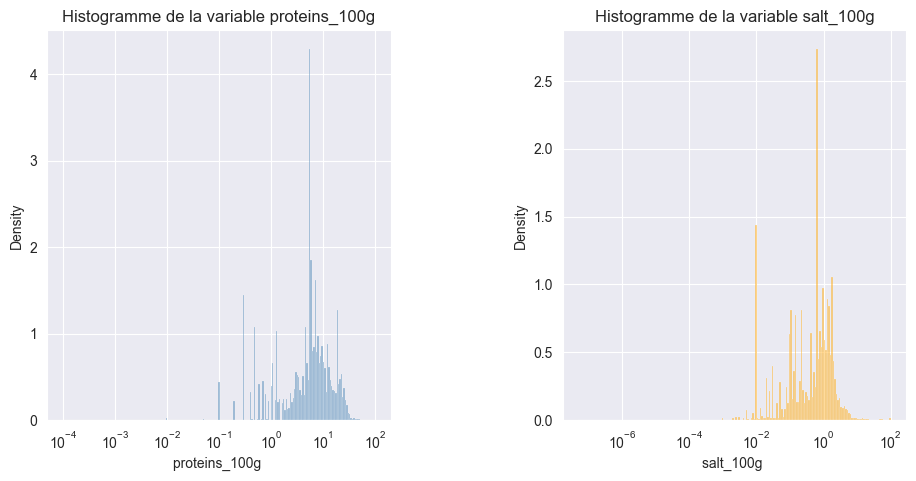

In [62]:
# Liste des variables à visualiser et leurs informations associées
variables=[('proteins_100g','steelblue',1),('salt_100g','orange',2)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(1, 3, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

La distribution des deux variables n'a pas changé, excepté les pic de valeurs correspondant aux médianes des groupes donc l'imputation ne semble pas biaiser significativement notre base de données.

Continuons nos imputations de variables quantitatives, corrélées celles-ci, avec deux autres méthodes : l'iterative imputer et le KNN imputer.

### Par les k plus proches voisins ou KNN imputer

Méthode KNN imputer : méthode d'imputation multivariée. Pour une valeur manquante, on calcule les distances entre l'ensemble des individus et on retient les plus petites distances. Les valeurs de ces "plus proches voisins" sont alors utilisées pour imputer la valeur manquante (moyenne ou médiane des plus proches voisins).

In [156]:
#  Création des données pour imputer
var= ['product_name','nutrition_grade_fr','pnns_groups_2','main_category_fr']
del_var=[]
for v in data_clean.columns :
    if v in var : del_var.append(v)
data_knn=data_clean.drop(del_var,axis=1)
data_knn.head()


pnns_groups_1  energy_100g  fat_100g  saturated-fat_100g  \
0                unknown          NaN       NaN                 NaN   
1                unknown       1883.0     20.00                12.5   
2                unknown          NaN       NaN                 NaN   
3                unknown       1481.0      4.17                 NaN   
4  Fruits and vegetables       1210.0     12.00                 7.0   

   carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
0                 NaN          NaN            NaN        NaN   
1               70.00         57.5           2.50    0.09652   
2                 NaN          NaN            NaN        NaN   
3               77.08          NaN           6.25        NaN   
4               23.00          0.0          22.00    2.16000   

   nutrition-score-fr_100g  
0                      NaN  
1                     22.0  
2                      NaN  
3                      NaN  
4                      6.0

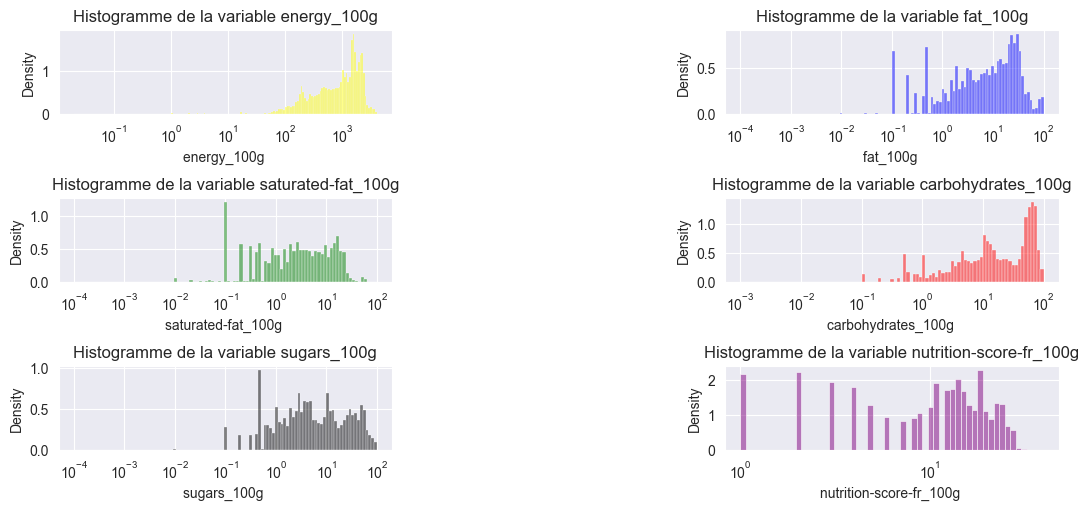

In [157]:
# Distribution des donnés avant imputation
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('carbohydrates_100g','red',4),('sugars_100g','black',5),('nutrition-score-fr_100g','purple',6)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.5, bottom=0.1, right=1.5, top=1.5, wspace=1, hspace=1)
    
    # # Création des histogrammes
    plt.subplot(3,2, place)
    sns.histplot(data=data_knn, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


In [181]:
# Transformation des groupes pnns1 en variable quantitatives pour le KNN imputer
cat_variables = data_knn[['pnns_groups_1']]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
cat_dummies.head()

pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                               False                          False   
1                               False                          False   
2                               False                          False   
3                               False                          False   
4                               False                          False   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                         False                         False   
4                         False                         False   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                False                                  False   
1                                False                                  False   
2                                False                                  False   
3                                False                                  False   
4                                 True                                  False   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   pnns_groups_1_unknown  
0                   True  
1                   True  
2                   True  
3                   True  
4                  False

In [182]:
data_knn = data_knn.drop(['pnns_groups_1'], axis=1)
data_knn = pd.concat([data_knn, cat_dummies], axis=1)
data_knn.head()

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0          NaN       NaN                 NaN                 NaN          NaN   
1       1883.0     20.00                12.5               70.00         57.5   
2          NaN       NaN                 NaN                 NaN          NaN   
3       1481.0      4.17                 NaN               77.08          NaN   
4       1210.0     12.00                 7.0               23.00          0.0   

   proteins_100g  salt_100g  nutrition-score-fr_100g  \
0            NaN        NaN                      NaN   
1           2.50    0.09652                     22.0   
2            NaN        NaN                      NaN   
3           6.25        NaN                      NaN   
4          22.00    2.16000                      6.0   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                               False                          False   
1                               False                          False   
2                               False                          False   
3                               False                          False   
4                               False                          False   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                         False                         False   
4                         False                         False   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                False                                  False   
1                                False                                  False   
2                                False                                  False   
3                                False                                  False   
4                                 True                                  False   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   pnns_groups_1_unknown  
0                   True  
1                   True  
2                   True  
3                   True  
4                  False

In [183]:
#  Scaling des données avant le KNN imputer
scaler = MinMaxScaler()
data_knn = pd.DataFrame(scaler.fit_transform(data_knn), columns = data_knn.columns)
data_knn.head()

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0          NaN       NaN                 NaN                 NaN          NaN   
1      0.47075    0.2000               0.125              0.7000        0.575   
2          NaN       NaN                 NaN                 NaN          NaN   
3      0.37025    0.0417                 NaN              0.7708          NaN   
4      0.30250    0.1200               0.070              0.2300        0.000   

   proteins_100g  salt_100g  nutrition-score-fr_100g  \
0            NaN        NaN                      NaN   
1         0.0250   0.000965                 0.672727   
2            NaN        NaN                      NaN   
3         0.0625        NaN                      NaN   
4         0.2200   0.021600                 0.381818   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                 0.0                            0.0   
1                                 0.0                            0.0   
2                                 0.0                            0.0   
3                                 0.0                            0.0   
4                                 0.0                            0.0   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                  0.0                                    0.0   
1                                  0.0                                    0.0   
2                                  0.0                                    0.0   
3                                  0.0                                    0.0   
4                                  1.0                                    0.0   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   pnns_groups_1_unknown  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    0.0

In [227]:
# Réalisation du KNN imputer et vérification  de la bonne imputation
imputer = KNNImputer(n_neighbors=5) #On garde les 5 plus proches voisins
data_knn = pd.DataFrame(imputer.fit_transform(data_knn),columns = data_knn.columns)
data_knn.isna().sum()


energy_100g                              0
fat_100g                                 0
saturated-fat_100g                       0
carbohydrates_100g                       0
sugars_100g                              0
proteins_100g                            0
salt_100g                                0
nutrition-score-fr_100g                  0
pnns_groups_1_Cereals and potatoes       0
pnns_groups_1_Composite foods            0
pnns_groups_1_Fat and sauces             0
pnns_groups_1_Fish Meat Eggs             0
pnns_groups_1_Fruits and vegetables      0
pnns_groups_1_Milk and dairy products    0
pnns_groups_1_Salty snacks               0
pnns_groups_1_Sugary snacks              0
pnns_groups_1_unknown                    0
dtype: int64

In [228]:
data_knn.head()

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0      0.33105    0.0876              0.0996              0.2230       0.1650   
1      0.47075    0.2000              0.1250              0.7000       0.5750   
2      0.33105    0.0876              0.0996              0.2230       0.1650   
3      0.37025    0.0417              0.0088              0.7708       0.1836   
4      0.30250    0.1200              0.0700              0.2300       0.0000   

   proteins_100g  salt_100g  nutrition-score-fr_100g  \
0         0.0462   0.120460                 0.352727   
1         0.0250   0.000965                 0.672727   
2         0.0462   0.120460                 0.352727   
3         0.0625   0.436424                 0.272727   
4         0.2200   0.021600                 0.381818   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                 0.0                            0.0   
1                                 0.0                            0.0   
2                                 0.0                            0.0   
3                                 0.0                            0.0   
4                                 0.0                            0.0   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                  0.0                                    0.0   
1                                  0.0                                    0.0   
2                                  0.0                                    0.0   
3                                  0.0                                    0.0   
4                                  1.0                                    0.0   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   pnns_groups_1_unknown  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    0.0

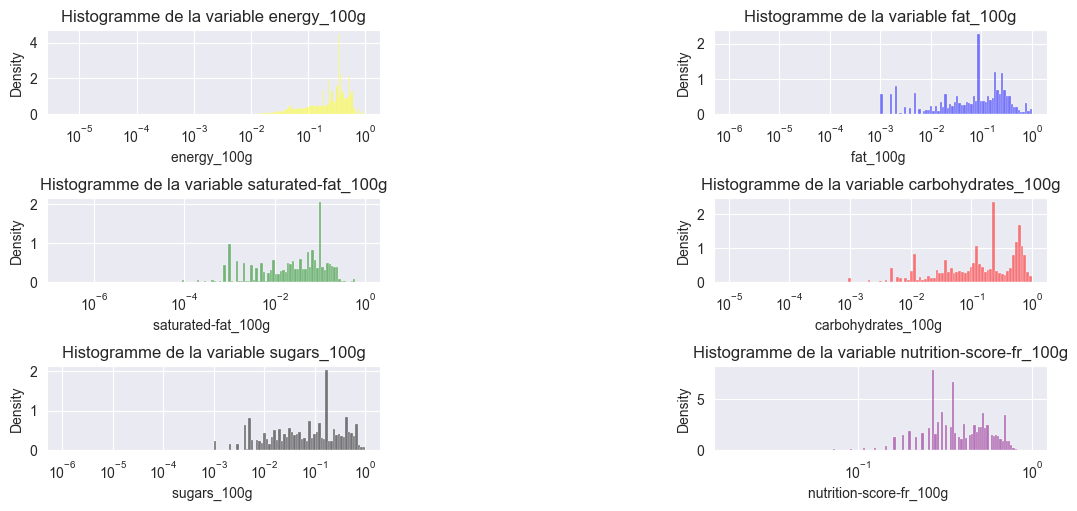

In [229]:
# Distribution des donnés après imputation
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('carbohydrates_100g','red',4),('sugars_100g','black',5),('nutrition-score-fr_100g','purple',6)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.5, bottom=0.1, right=1.5, top=1.5, wspace=1, hspace=1)
    
    # # Création des histogrammes
    plt.subplot(3, 2, place)
    sns.histplot(data=data_knn, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


### Par l'iterative imputer
Méthode qui utilise un processus itératif basé sur des modèles de régression pour prédire les valeurs manquantes en fonction des autres variables du jeu de données.

Première étape : imputation des valeurs manquantes par la moyenne ou la médiane

Deuxième étape : chaque variable avec des valeurs manquantes sont traitée comme variable cible par rapport aux autres. Un apprentissage automatique modélise les relations entre la variable cible et les autres.

Troisième étape : La modélisation de ces relations est utilisée pour prédire les valeurs manquantes à partir des autres variables.

Et on répète les deuxièmes et troisième étapes jusqu'à ce qu'il n'y ait plus de changements significatifs dans les valeurs imputées ou à partir d'un certain nombre d'itérations.

In [158]:
#  Création des données pour imputer
var= ['product_name','nutrition_grade_fr','pnns_groups_2','main_category_fr']
del_var=[]
for v in data_clean.columns :
    if v in var : del_var.append(v)
data_itimp=data_clean.drop(del_var,axis=1)
data_itimp.head()

pnns_groups_1  energy_100g  fat_100g  saturated-fat_100g  \
0                unknown          NaN       NaN                 NaN   
1                unknown       1883.0     20.00                12.5   
2                unknown          NaN       NaN                 NaN   
3                unknown       1481.0      4.17                 NaN   
4  Fruits and vegetables       1210.0     12.00                 7.0   

   carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
0                 NaN          NaN            NaN        NaN   
1               70.00         57.5           2.50    0.09652   
2                 NaN          NaN            NaN        NaN   
3               77.08          NaN           6.25        NaN   
4               23.00          0.0          22.00    2.16000   

   nutrition-score-fr_100g  
0                      NaN  
1                     22.0  
2                      NaN  
3                      NaN  
4                      6.0

In [159]:
data_itimp.dtypes

pnns_groups_1               object
energy_100g                float64
fat_100g                   float64
saturated-fat_100g         float64
carbohydrates_100g         float64
sugars_100g                float64
proteins_100g              float64
salt_100g                  float64
nutrition-score-fr_100g    float64
dtype: object

In [160]:
data_itimp.describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  66638.000000  63247.000000        62232.000000        62791.000000   
mean    1095.769950     13.389602            5.335795           27.946368   
std      782.077231     17.082771            8.240013           27.370702   
min        0.000000      0.000000            0.000000            0.000000   
25%      393.000000      1.100000            0.300000            4.400000   
50%     1009.000000      6.600000            1.900000           14.800000   
75%     1643.000000     21.000000            7.300000           53.300000   
max     4000.000000    100.000000          100.000000          100.000000   

        sugars_100g  proteins_100g     salt_100g  nutrition-score-fr_100g  
count  62523.000000   66008.000000  62780.000000             60741.000000  
mean      13.211141       7.503197      1.130506                 8.433282  
std       18.776997       7.612317      4.365458                 9.105679  
min        0.000000       0.000000      0.000000               -15.000000  
25%        1.000000       1.700000      0.070000                 1.000000  
50%        4.200000       5.800000      0.508000                 8.000000  
75%       17.000000      10.300000      1.200000                15.000000  
max      100.000000     100.000000    100.000000                40.000000

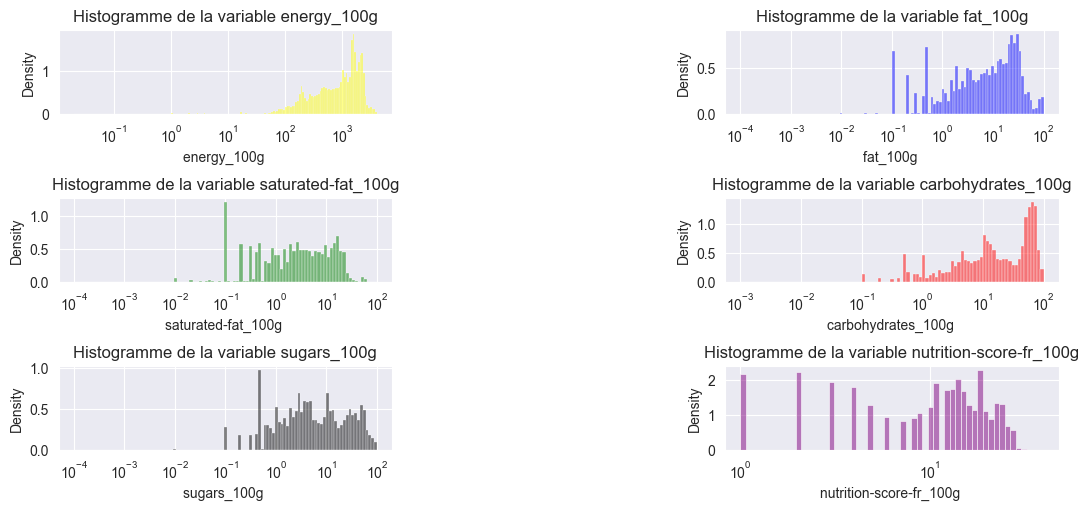

In [162]:
# Distribution des donnés avant imputation
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('carbohydrates_100g','red',4),('sugars_100g','black',5),('nutrition-score-fr_100g','purple',6)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.5, bottom=0.1, right=1.5, top=1.5, wspace=1, hspace=1)
    
    # # Création des histogrammes
    plt.subplot(3, 2, place)
    sns.histplot(data=data_itimp, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


In [163]:
# Transformation des groupes pnns1 en variable quantitatives pour l'iterative imputer
cat_variables = data_itimp[['pnns_groups_1']]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
data_itimp = data_itimp.drop(['pnns_groups_1'], axis=1)
data_itimp = pd.concat([data_itimp, cat_dummies], axis=1)
data_itimp.head()


energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0          NaN       NaN                 NaN                 NaN          NaN   
1       1883.0     20.00                12.5               70.00         57.5   
2          NaN       NaN                 NaN                 NaN          NaN   
3       1481.0      4.17                 NaN               77.08          NaN   
4       1210.0     12.00                 7.0               23.00          0.0   

   proteins_100g  salt_100g  nutrition-score-fr_100g  \
0            NaN        NaN                      NaN   
1           2.50    0.09652                     22.0   
2            NaN        NaN                      NaN   
3           6.25        NaN                      NaN   
4          22.00    2.16000                      6.0   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                               False                          False   
1                               False                          False   
2                               False                          False   
3                               False                          False   
4                               False                          False   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                         False                         False   
4                         False                         False   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                False                                  False   
1                                False                                  False   
2                                False                                  False   
3                                False                                  False   
4                                 True                                  False   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   pnns_groups_1_unknown  
0                   True  
1                   True  
2                   True  
3                   True  
4                  False

In [165]:
# Réalisation de l'iterative imputer en imposant les valeurs max et min pour plus de pertinence
imputer = IterativeImputer(random_state=42,min_value = [0,0,0,0,0,0,0,-15,0,0,0,0,0,0,0,0,0],max_value = [4000,100,100,100,100,100,100,40,1,1,1,1,1,1,1,1,1])
imputed = imputer.fit_transform(data_itimp)
df_imputed = pd.DataFrame(imputed, columns=data_itimp.columns)

round(df_imputed, 2)

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
0          1116.55     13.00                4.80               29.62   
1          1883.00     20.00               12.50               70.00   
2          1116.55     13.00                4.80               29.62   
3          1481.00      4.17                1.66               77.08   
4          1210.00     12.00                7.00               23.00   
...            ...       ...                 ...                 ...   
86237       804.11      9.70                3.64               21.19   
86238      1116.55     13.00                4.80               29.62   
86239        21.00      0.20                0.20                0.50   
86240       782.73      9.45                2.91                6.87   
86241      1648.93     22.27                2.25               38.16   

       sugars_100g  proteins_100g  salt_100g  nutrition-score-fr_100g  \
0            13.46           7.49       2.28                     8.95   
1            57.50           2.50       0.10                    22.00   
2            13.46           7.49       2.28                     8.95   
3            35.23           6.25       1.69                    11.76   
4             0.00          22.00       2.16                     6.00   
...            ...            ...        ...                      ...   
86237        14.09           2.79       0.34                     0.31   
86238        13.46           7.49       2.28                     8.95   
86239         0.50           0.50       0.03                     2.00   
86240         3.30          18.05       2.01                     8.82   
86241         0.87           9.89       1.75                     9.29   

       pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                     0.0                            0.0   
1                                     0.0                            0.0   
2                                     0.0                            0.0   
3                                     0.0                            0.0   
4                                     0.0                            0.0   
...                                   ...                            ...   
86237                                 0.0                            0.0   
86238                                 0.0                            0.0   
86239                                 0.0                            0.0   
86240                                 0.0                            0.0   
86241                                 0.0                            0.0   

       pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3                               0.0                           0.0   
4                               0.0                           0.0   
...                             ...                           ...   
86237                           0.0                           0.0   
86238                           0.0                           0.0   
86239                           0.0                           0.0   
86240                           0.0                           1.0   
86241                           0.0                           0.0   

       pnns_groups_1_Fruits and vegetables  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      1.0   
...                                    ...   
86237                                  1.0   
86238                                  0.0   
86239                                  0.0   
86240                                  0.0   
86241            

In [166]:
df_imputed.isna().sum()

energy_100g                              0
fat_100g                                 0
saturated-fat_100g                       0
carbohydrates_100g                       0
sugars_100g                              0
proteins_100g                            0
salt_100g                                0
nutrition-score-fr_100g                  0
pnns_groups_1_Cereals and potatoes       0
pnns_groups_1_Composite foods            0
pnns_groups_1_Fat and sauces             0
pnns_groups_1_Fish Meat Eggs             0
pnns_groups_1_Fruits and vegetables      0
pnns_groups_1_Milk and dairy products    0
pnns_groups_1_Salty snacks               0
pnns_groups_1_Sugary snacks              0
pnns_groups_1_unknown                    0
dtype: int64

In [167]:
df_imputed.describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  86242.000000  86242.000000        86242.000000        86242.000000   
mean    1085.265277     13.124297            5.186471           27.398459   
std      702.807487     15.179644            7.229993           24.715030   
min        0.000000      0.000000            0.000000            0.000000   
25%      520.000000      2.000000            0.500000            6.800000   
50%     1080.000000      9.702698            3.026896           19.536768   
75%     1522.352021     17.000000            6.697226           48.840174   
max     4000.000000    100.000000          100.000000          100.000000   

        sugars_100g  proteins_100g     salt_100g  nutrition-score-fr_100g  \
count  86242.000000   86242.000000  86242.000000             86242.000000   
mean      13.151494       7.415553      1.191305                 8.445176   
std       16.763626       7.030519      3.756502                 8.117936   
min        0.000000       0.000000      0.000000               -15.000000   
25%        1.800000       2.100000      0.100000                 2.000000   
50%        6.300000       6.300000      0.644557                 8.948622   
75%       15.277842       9.690000      1.600200                14.000000   
max      100.000000     100.000000    100.000000                40.000000   

       pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
count                        86242.000000                   86242.000000   
mean                             0.095591                       0.077271   
std                              0.294032                       0.267022   
min                              0.000000                       0.000000   
25%                              0.000000                       0.000000   
50%                              0.000000                       0.000000   
75%                              0.000000                       0.000000   
max                              1.000000                       1.000000   

       pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
count                  86242.000000                  86242.000000   
mean                       0.056399                      0.089330   
std                        0.230693                      0.285221   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                        0.000000                      0.000000   
max                        1.000000                      1.000000   

       pnns_groups_1_Fruits and vegetables  \
count                         86242.000000   
mean                              0.074117   
std                               0.261963   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       pnns_groups_1_Milk and dairy products  pnns_groups_1_Salty snacks  \
count                           86242.000000                86242.000000   
mean                                0.099557                    0.031678   
std                                 0.299410                    0.175143   
min                                 0.000000                    0.000000   
25%                                 0.000000                    0.000000   
50%                                 0.000000                    0.000000   
75%                                 0.000000                    0.000000   
max                                 1.000000                    1.000000   

       pnns_groups_1_Sugary snacks  pnns_groups_1_unknown  
count                 86242.000000           86242.000000  
mean                      0.144512               0.233239  
std                       0.35161

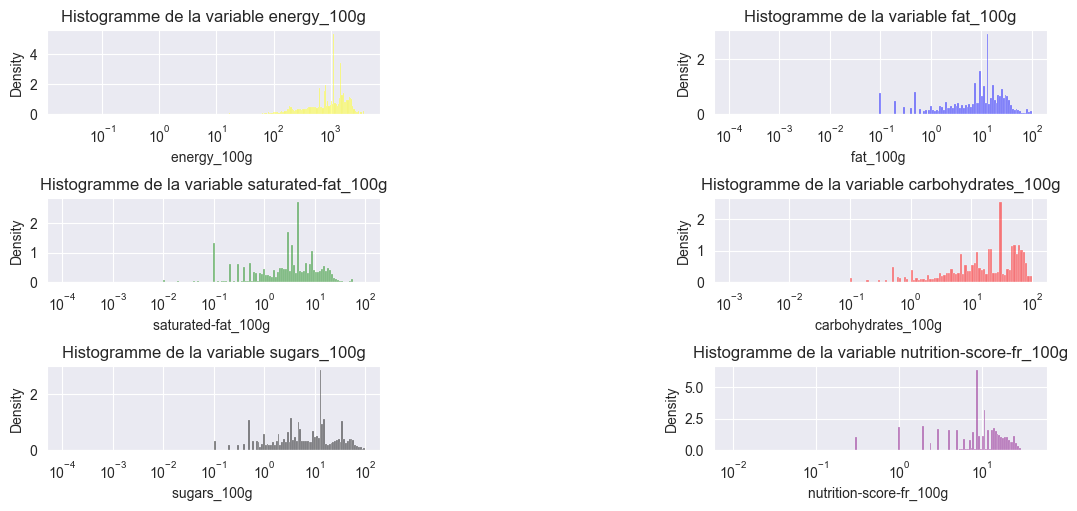

In [177]:
# Distribution des donnés après imputation
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('carbohydrates_100g','red',4),('sugars_100g','black',5),('nutrition-score-fr_100g','purple',6)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.5, bottom=0.1, right=1.5, top=1.5, wspace=1, hspace=1)
    
    # # Création des histogrammes
    plt.subplot(3, 2, place)
    sns.histplot(data=df_imputed, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


L'imputation par le KNN imputer ou l'iterative imputer entraine des modifications de distributions des variables. Nous choisirons les données issus du KNN imputer pour l'ACP.

## ACP : Analyse en Composante Principale 

C'est une méthode qui consiste à transformer des variables en nouvelles variables (combinaisons linéaires des variables initiales qui maximisent la variance des données), nommées « composantes principales » ou axes principaux. Elle permet de résumer l'information en réduisant le nombre de variables.

Pour commencer, on ne garde que les variables quantitatives (contrainte de l'ACP) et il est essentiel de centrer-réduire les données pour que chaque variable ait le même poids. En effet, puisque l'on calcule la distance entre individus, les différences d'échelles peuvent biaiser les résultats.

In [230]:
# suppression des colonnes non numériques
data_knn_quant = data_knn.iloc[:, [0,1,2,3,4,5,6,7]]

# On instancie notre scaler : 
scaler = StandardScaler()

# On effectue le scaling
data_knn_quant_scaled = scaler.fit_transform(data_knn_quant)

# On le transforme en DataFrame : 
data_knn_quant_scaled = pd.DataFrame(data_knn_quant_scaled)

# On vérifie le scaling en l'affichant
data_knn_quant_scaled.describe().round(2)


0         1         2         3         4         5         6  \
count  86242.00  86242.00  86242.00  86242.00  86242.00  86242.00  86242.00   
mean       0.00     -0.00     -0.00      0.00      0.00      0.00     -0.00   
std        1.00      1.00      1.00      1.00      1.00      1.00      1.00   
min       -1.57     -0.80     -0.73     -1.03     -0.80     -1.01     -0.37   
25%       -0.87     -0.71     -0.70     -0.87     -0.72     -0.77     -0.36   
50%       -0.00     -0.28     -0.39     -0.37     -0.41     -0.28     -0.28   
75%        0.60      0.38      0.52      0.94      0.24      0.34     -0.13   
max        3.90      5.12     12.32      2.86      4.38     13.05     15.34   

              7  
count  86242.00  
mean      -0.00  
std        1.00  
min       -2.67  
25%       -0.86  
50%       -0.21  
75%        0.73  
max        3.78

Nous avons bien une moyenne à 0 et un écart-type à 1 pour toutes nos variables. Nous pouvons donc maintenant effectuer l'ACP.

In [231]:
#  Réalisation de l'ACP  avec 8 composantes
pca = PCA(n_components=8)
pca.fit(data_knn_quant_scaled)
# % d'explication de la variance pour chaque composante
pca.explained_variance_ratio_


array([0.37887201, 0.21702392, 0.12657844, 0.11984253, 0.07106762,
       0.04107263, 0.03744094, 0.00810191])

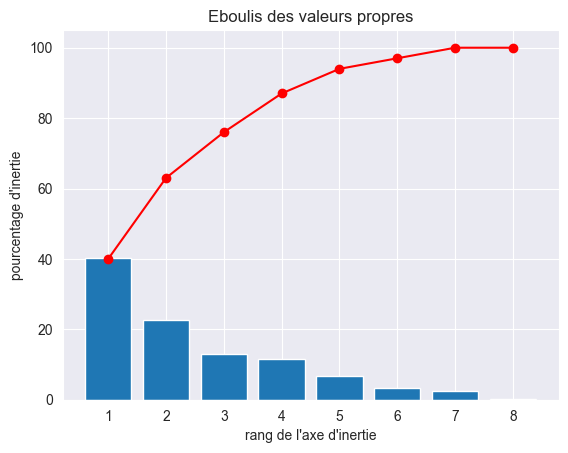

In [186]:
# Traçons le diagramme d'éboulis
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()   #Somme cumulée des pourcentage d'explication de variance

x_list = range(1, 9)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Avec les 3 premières composantes, plus de 70% de la variance des données peut être expliquée. Nous garderons donc ces 3 premières composantes.

Regardonc les plus en détails : 

In [234]:
pcs = pd.DataFrame(pca.components_)
pcs=pcs.iloc[:3]
variables_name=['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']
pcs.columns = variables_name
pcs.index = ['F1','F2','F3']
pcs.round(2)

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
F1         0.53      0.47                0.45                0.21   
F2        -0.05      0.30                0.27               -0.57   
F3         0.02     -0.02                0.11               -0.04   

    sugars_100g  proteins_100g  salt_100g  nutrition-score-fr_100g  
F1         0.19           0.10      -0.02                     0.46  
F2        -0.61           0.35       0.05                    -0.07  
F3         0.09          -0.12       0.98                    -0.07

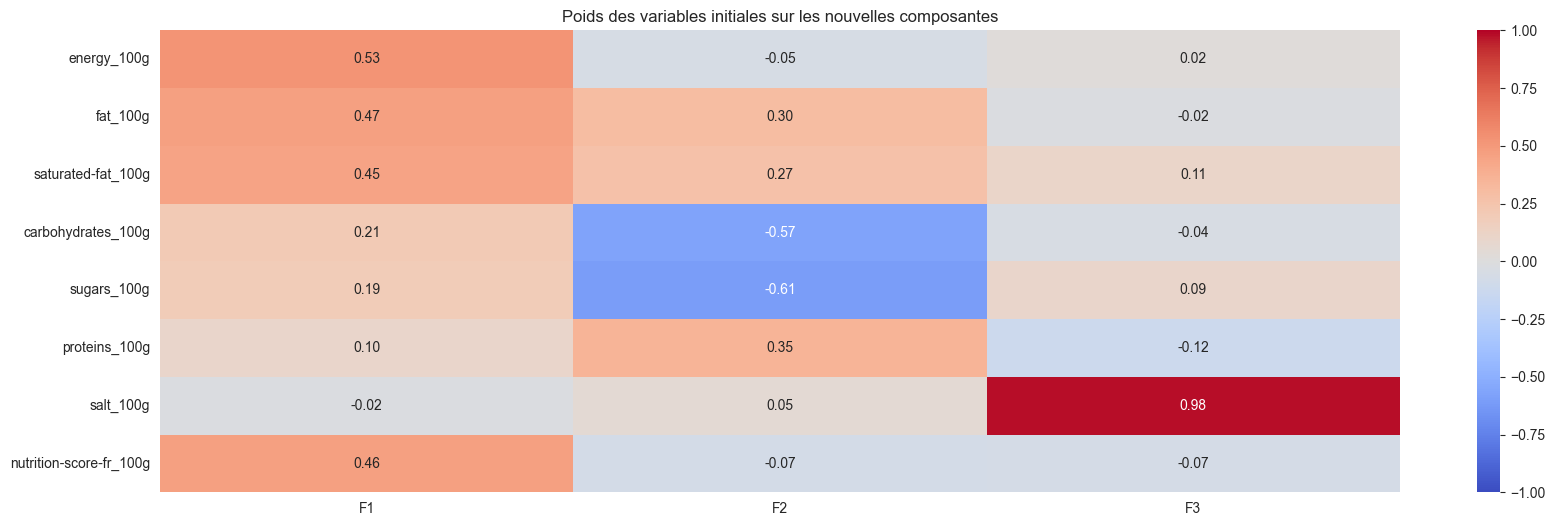

In [235]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Poids des variables initiales sur les nouvelles composantes")
plt.show()

Traçons les cercles de corrélations :

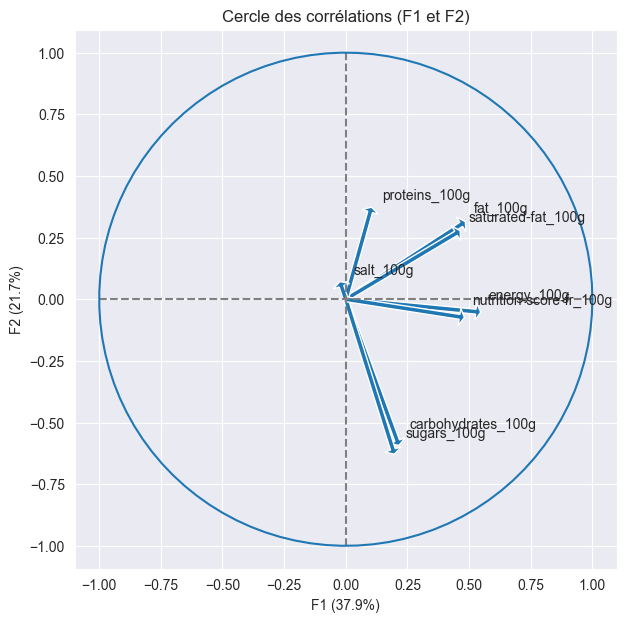

In [242]:
x, y = 0,1    #0 for PC1 / 1 for PC2
fig, ax = plt.subplots(figsize=(7, 7))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.02, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             variables_name[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

Pour l'axe F1, on voit que les variables liées aux graisses, celle de l'énergie et celle du nutriscore sont positivement corrélées à F1.

Pour l'axe F2, on voit que les variables liées aux sucres et carbohydrates sont les plus négativement corrélées à F2.


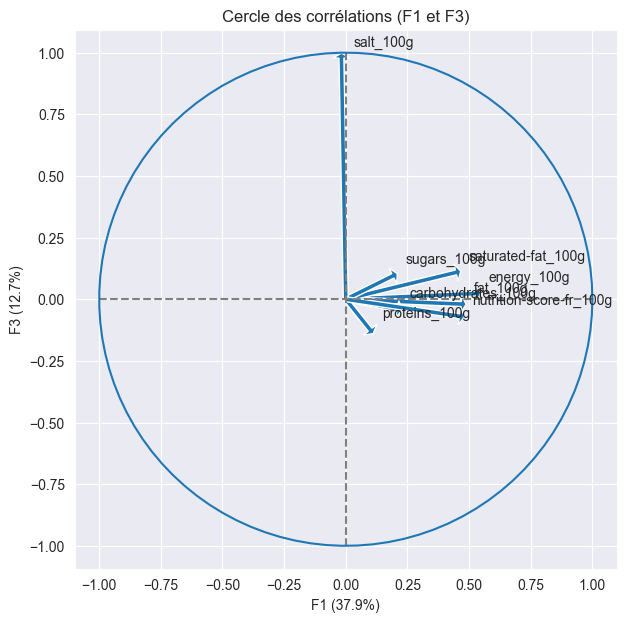

In [241]:
x, y = 0,2   #0 for PC1 / 2 for PC3
fig, ax = plt.subplots(figsize=(7, 7))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[2, i],  #2 for PC3
             head_width=0.07,
             head_length=0.02, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[2, i] + 0.05,
             variables_name[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

Pour l'axe F3, on voit que la variable liée au sel est la plus positivement corrélée à F3.


Projetons les individus sur le premier plan factoriel, c’est-à-dire sur un plan composé des 2 premières composantes principales F1 et F2 :

In [243]:
pca_proj = pca.transform(data_knn_quant_scaled)
pca_proj[:3]

array([[-0.01998875,  0.09172528,  1.64363039, -0.15976069, -0.22027872,
         0.28870999,  0.33862911, -0.31894772],
       [ 2.59028027, -2.36522745, -0.13168138, -0.35072164,  0.55470141,
         0.114158  ,  0.33000519,  0.207729  ],
       [-0.01998875,  0.09172528,  1.64363039, -0.15976069, -0.22027872,
         0.28870999,  0.33862911, -0.31894772]])

In [244]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



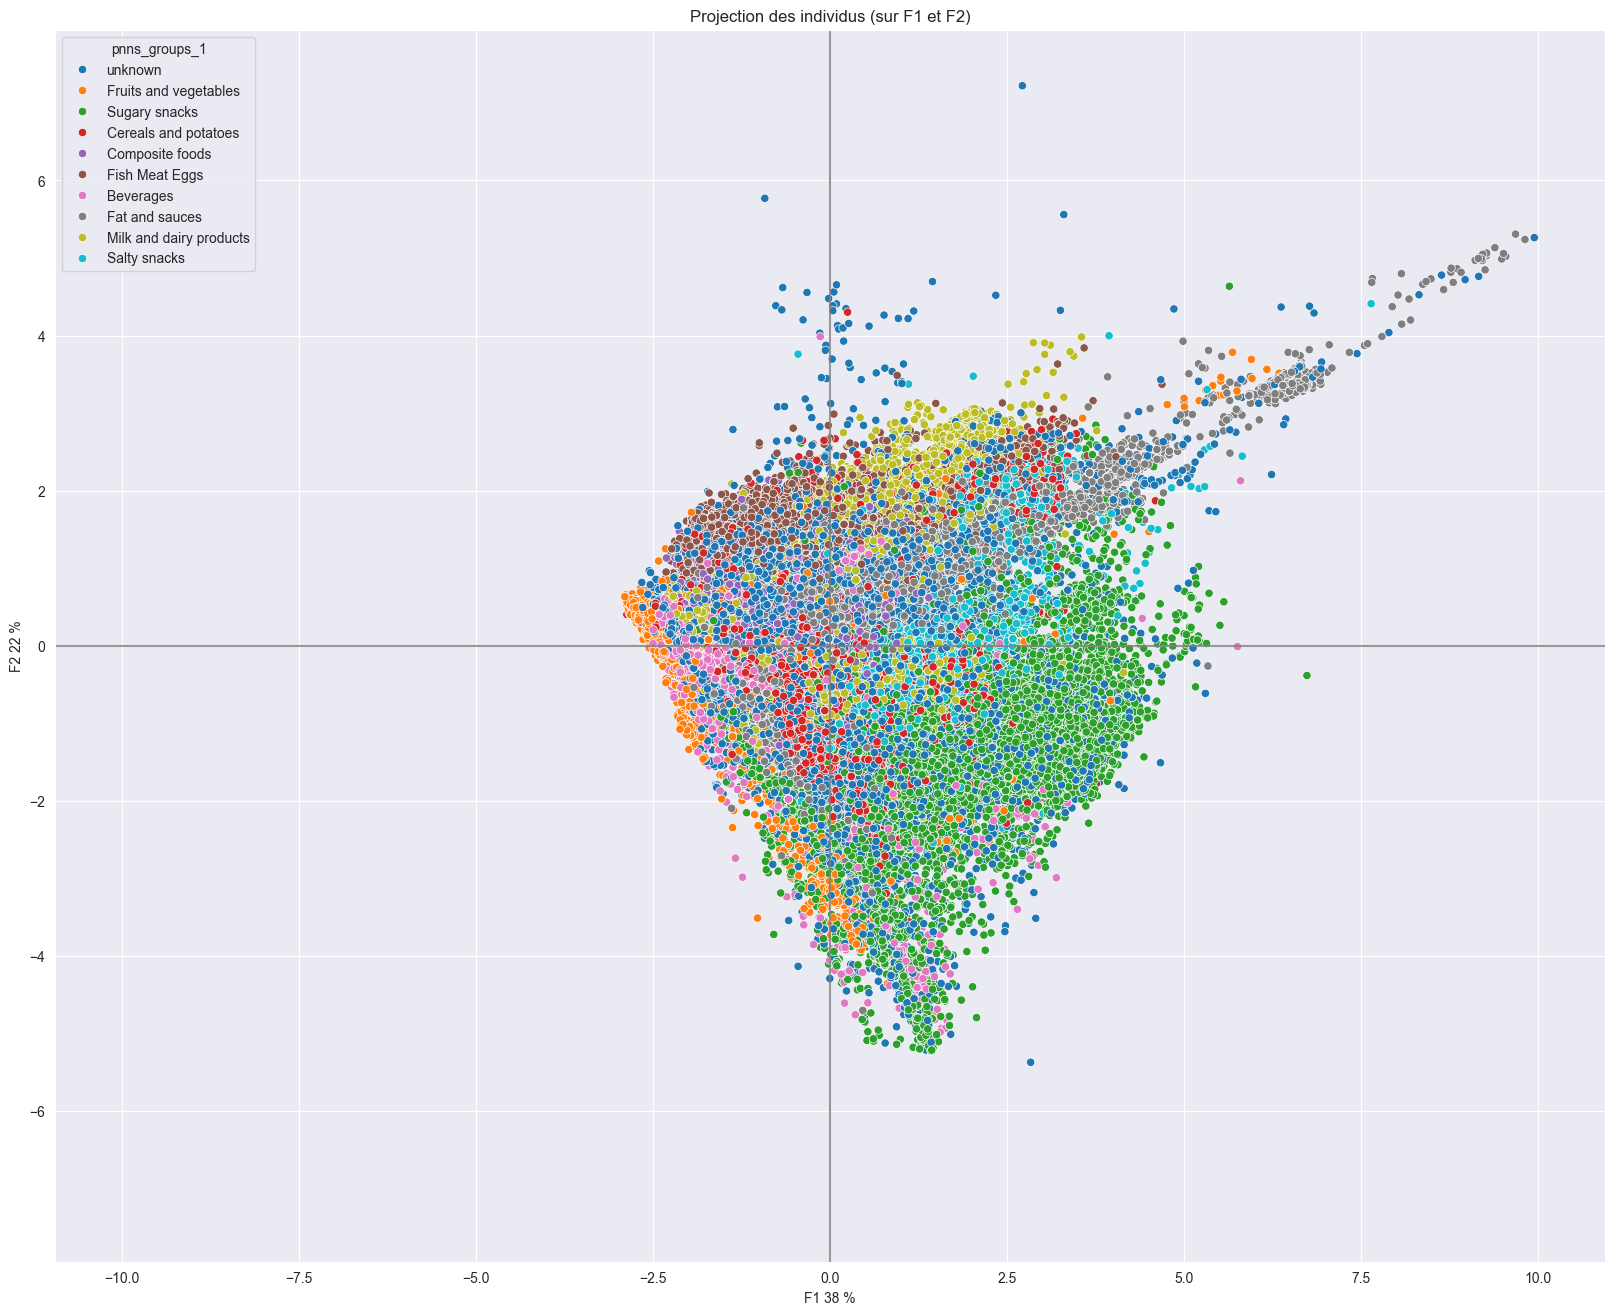

In [248]:
x_y = [0,1]
display_factorial_planes(pca_proj, x_y,  pca, figsize=(20,16),clusters=data_clean['pnns_groups_1'])

Les valeurs les plus importantes de F1 sont celles des individus du groupes "Fat and sauces" et on sait que F1 est corrélé avec les graisses, énergie et nutriscore. On peut donc supposer que l'axe F1 correspond au niveau de graisses dans les produits. En effet, les individus du groupe "Fruits and vegetables", donc des aliments peu gras, ont les valeurs F1 les plus basses.

Les valeurs les plus basses de F2 sont celles des individus du groupes "Sugary snacks" et on sait que F2 est anti-corrélé avec les sucres et carbohydrates. On peut donc supposer que l'axe F2 correspond inversement au niveau de sucres dans les produits. En effet, les individus du groupe "Fat and sauces", donc des aliments peu sucrés, ont les valeurs F2 les plus hautes.

Puis on projette sur F2 et F3 : 

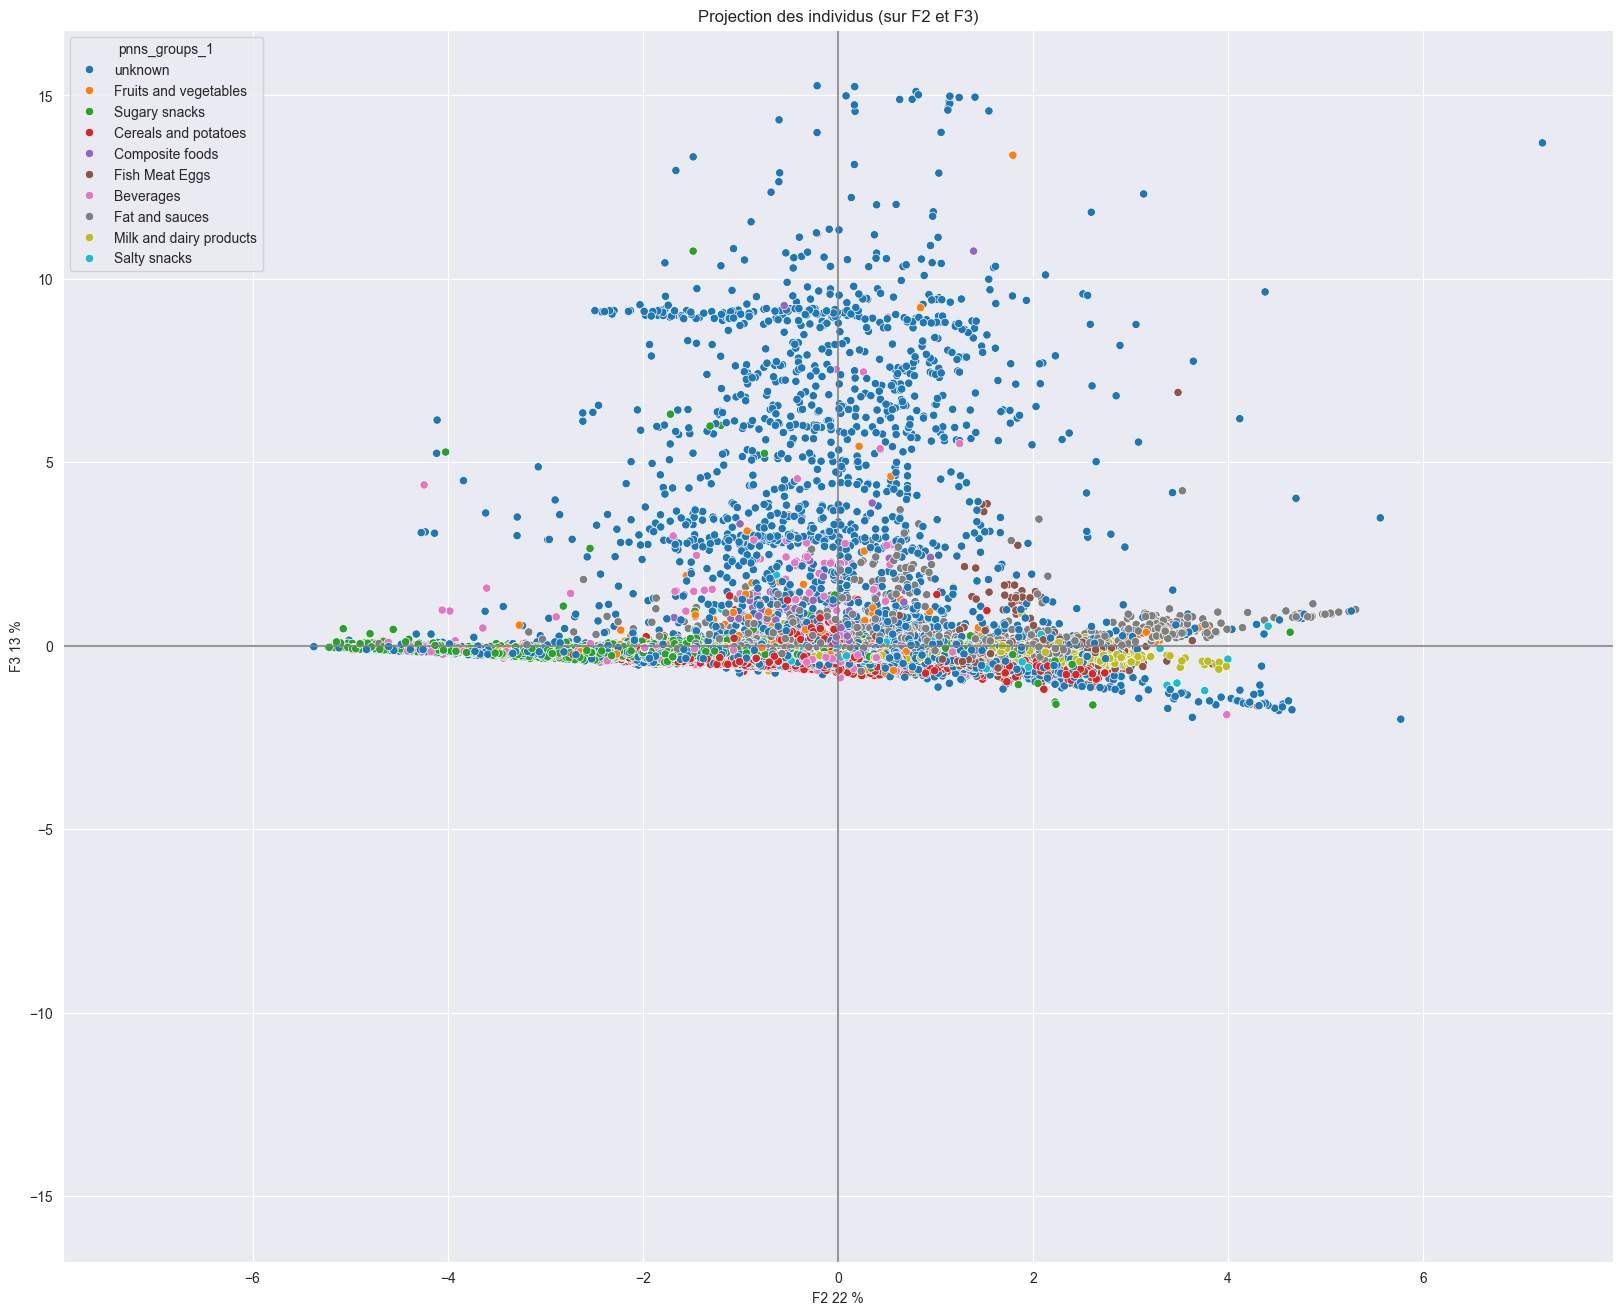

In [250]:
x_y = 1,2
display_factorial_planes(pca_proj, x_y,  pca, figsize=(20,16),clusters=data_clean['pnns_groups_1'])

Concernant l'axe F3, il existe peu de différences entre les groupes d'individus (si l'on s'affranchit du groupe "unknown") et on sait que F3 est corrélé avec le sel. Il apparait donc qu'il existe peu de différences entre les groupes pour cette variables.